<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Credit-Card-Approval---Classification" data-toc-modified-id="Credit-Card-Approval---Classification-1">Credit Card Approval - Classification</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Version-1" data-toc-modified-id="Version-1-1.0.1">Version 1</a></span></li><li><span><a href="#Author-:-Anuj-Dubey" data-toc-modified-id="Author-:-Anuj-Dubey-1.0.2">Author : Anuj Dubey</a></span></li></ul></li></ul></li><li><span><a href="#Approach:" data-toc-modified-id="Approach:-2">Approach:</a></span><ul class="toc-item"><li><span><a href="#Learnings-from-EDA:" data-toc-modified-id="Learnings-from-EDA:-2.1">Learnings from EDA:</a></span></li><li><span><a href="#Assumption:" data-toc-modified-id="Assumption:-2.2">Assumption:</a></span></li><li><span><a href="#Approach:" data-toc-modified-id="Approach:-2.3">Approach:</a></span></li></ul></li><li><span><a href="#Importing-Libraries" data-toc-modified-id="Importing-Libraries-3">Importing Libraries</a></span></li><li><span><a href="#Data-Preparation-and-cleaning" data-toc-modified-id="Data-Preparation-and-cleaning-4">Data Preparation and cleaning</a></span><ul class="toc-item"><li><span><a href="#Selecting-columns-for-classification" data-toc-modified-id="Selecting-columns-for-classification-4.1">Selecting columns for classification</a></span></li><li><span><a href="#Handling-missing-values" data-toc-modified-id="Handling-missing-values-4.2">Handling missing values</a></span></li><li><span><a href="#Splitting-the-dataset-for-training-and-testing" data-toc-modified-id="Splitting-the-dataset-for-training-and-testing-4.3">Splitting the dataset for training and testing</a></span></li><li><span><a href="#Scaling-continuous-variables" data-toc-modified-id="Scaling-continuous-variables-4.4">Scaling continuous variables</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-5">Classification</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression(Baseline-Model)" data-toc-modified-id="Logistic-Regression(Baseline-Model)-5.1">Logistic Regression(Baseline Model)</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-5.2">Random Forest</a></span></li><li><span><a href="#Adaptive-Boosting" data-toc-modified-id="Adaptive-Boosting-5.3">Adaptive Boosting</a></span></li><li><span><a href="#Extreme-Gradient-Boosting" data-toc-modified-id="Extreme-Gradient-Boosting-5.4">Extreme Gradient Boosting</a></span></li></ul></li><li><span><a href="#Model-Validation" data-toc-modified-id="Model-Validation-6">Model Validation</a></span><ul class="toc-item"><li><span><a href="#Finding-optimal-threshold-using-ROC-AUC" data-toc-modified-id="Finding-optimal-threshold-using-ROC-AUC-6.1">Finding optimal threshold using ROC-AUC</a></span></li><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-6.2">Confusion Matrix</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6.3">Conclusion</a></span></li><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-6.4">Saving the model</a></span></li></ul></li></ul></div>

## Credit Card Approval - Classification
#### Version 1
#### Author : Anuj Dubey

## Approach:

### Learnings from EDA: 
- The columns capital_gain and capital_loss have mostly zeros present in them. This need to be mitigated
- Further the columns mentioned above can be combined to form net_capital_gain
- Most of the values for derived column net_capital_gain still remain zero. This needs to be mitigated
- Since the newly derived column capital_net_gain has a very high correlation with captial_gain and capital_loss, the latter two columns can be dropped
- The values for column hours_per_week mostly remain close to 40. This column needs to be scaled before passing it to the model
- Column asset_class_cd which has a lot of missing values, also has some garbage values(like -1 and 01) which needs to be cleaned
- Column education_level already has ordinal encoding present in the sense of education_num column and it doesn't need any special encoding before classification

### Assumption:

- ABC bank is a growing bank aiming to increase its customer base
- To ensure that, more and more credits cards should be approved ensuring credit card default is avoided
- Thus for this problem, we will focus on having high precision(ensuring that a customer is denied creditd card if there is a very high probabilty of non repayment) of 0 class(Not Approved)

### Approach:

- Use learnings from EDA to prepare data for classification
- Use Logistic Regression model as baseline and compare its performance with Random Forest, Adaptive Boosting, Extreme Gradient Boosting using AUC-ROC metric(hyperparamters to be tuned using Grid Search)
- Pick optimal threshold probability to ensure high precision in 0 class(Not Approved)

## Importing Libraries

In [42]:
# import required libraries

# for data manipulation
import os
import numpy as np
import pandas as pd
import collections
from collections import Counter
from sklearn.impute import SimpleImputer


# for visualization
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

# to supress warnings
import warnings
warnings.filterwarnings('ignore')

# for classification
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, accuracy_score, roc_curve 
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle

# for handling class imbalance
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# setting parameters for plot
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8
rcParams['figure.max_open_warning'] = 0

# setting seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


## Data Preparation and cleaning

### Selecting columns for classification

In [2]:
credit_approval_data = pd.read_csv("../input/eda_output.csv")

In [3]:
credit_approval_data.columns

Index(['Unnamed: 0', 'user_id', 'gender', 'date_of_birth', 'workclass',
       'education_level', 'education_num', 'marital_status', 'occupation',
       'relationship', 'capital_gain', 'capital_loss', 'hours_per_week',
       'approved', 'address', 'email', 'inquiry_purpose_code',
       'institute_type', 'account_type', 'asset_class_cd', 'asset_code',
       'portfolio_type', 'age', 'capital_net_gain', 'email_domain'],
      dtype='object')

In [4]:
columns = ['user_id', 'gender', 'workclass',
       'education_num', 'marital_status', 'occupation',
       'relationship', 'hours_per_week',
       'approved', 'inquiry_purpose_code',
       'institute_type', 'account_type', 'asset_class_cd', 'asset_code',
       'portfolio_type', 'age', 'capital_net_gain']

In [5]:
credit_approval_data = credit_approval_data[columns]

### Handling missing values

In [6]:
cat_columns = ['portfolio_type', 'asset_code']
cat_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

for c in cat_columns:
    credit_approval_data[c] = cat_imp.fit_transform(credit_approval_data[[c]]).ravel()

credit_approval_data['inquiry_purpose_code'] =credit_approval_data['inquiry_purpose_code'].replace(np.nan,2000)
credit_approval_data['inquiry_purpose_code'] = credit_approval_data['inquiry_purpose_code'].astype(str)
credit_approval_data['inquiry_purpose_code'] =credit_approval_data['inquiry_purpose_code'].replace('2000.0','Unknown')

credit_approval_data['asset_class_cd'] =credit_approval_data['asset_class_cd'].replace(np.nan,'Unknown')

In [7]:
credit_approval_data['asset_class_cd'] =credit_approval_data['asset_class_cd'].replace('?','Unknown')
credit_approval_data['asset_class_cd'] =credit_approval_data['asset_class_cd'].replace('01','Unknown')
credit_approval_data['asset_class_cd'] =credit_approval_data['asset_class_cd'].replace('-1','Unknown')

In [8]:
def percentage(part, whole):
    return 100 * float(part) / float(whole)

In [9]:
row_count =credit_approval_data.shape[0]

for c in credit_approval_data.columns:
    m_count = credit_approval_data[credit_approval_data[c].isnull()][c].shape[0]
    if m_count > 0:    
        print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

In [10]:
np.unique(credit_approval_data['asset_class_cd'])

array(['B', 'D', 'L', 'M', 'S', 'Unknown'], dtype=object)

In [11]:
cat_columns = ['gender', 'workclass',
             'marital_status', 'occupation', 'relationship',
             'inquiry_purpose_code', 'institute_type', 'account_type',
             'asset_class_cd', 'asset_code', 'portfolio_type']
credit_approval_data = pd.get_dummies(credit_approval_data, columns=cat_columns)

### Splitting the dataset for training and testing

In [12]:
# Split dataset into train and test dataset

X = credit_approval_data.drop(['approved', 'user_id'],1)
y = credit_approval_data['approved']

X_train, X_test, y_train, y_test = tts(X, y, test_size= 0.30, random_state=RANDOM_SEED)

print('Shape of original dataset: ',credit_approval_data.shape)
print('Shape of training dataset: ',X_train.shape)
print('Shape of test dataset: ',X_test.shape)

print('\nNo. of fradulent cases in complete dataset: ', credit_approval_data['approved'].sum())
print('No. of approved cases in training dataset: ', y_train.sum())
print('No. of approved cases in test dataset: ', y_test.sum())

Shape of original dataset:  (45222, 122)
Shape of training dataset:  (31655, 120)
Shape of test dataset:  (13567, 120)

No. of fradulent cases in complete dataset:  11208
No. of approved cases in training dataset:  7883
No. of approved cases in test dataset:  3325


Note: training and testing sets are created in such a way that they both have enough examples for both the classes

### Scaling continuous variables

In [13]:
sc = StandardScaler()

X_train['scaled_capital_net_gain'] = sc.fit_transform(X_train[['capital_net_gain']])
X_test['scaled_capital_net_gain'] = sc.transform(X_test[['capital_net_gain']])

X_train.drop('capital_net_gain',1,inplace=True)
X_test.drop('capital_net_gain',1,inplace=True)

X_train['scaled_age'] = sc.fit_transform(X_train[['age']])
X_test['scaled_age'] = sc.transform(X_test[['age']])

X_train.drop('age',1,inplace=True)
X_test.drop('age',1,inplace=True)

X_train['scaled_hours_per_week'] = sc.fit_transform(X_train[['hours_per_week']])
X_test['scaled_hours_per_week'] = sc.transform(X_test[['hours_per_week']])

X_train.drop('hours_per_week',1,inplace=True)
X_test.drop('hours_per_week',1,inplace=True)


# Let's see the distribution of all variables once again in training dataset...
pd.options.display.float_format = '{:.4f}'.format
X_train[['scaled_capital_net_gain', 'scaled_age', 'scaled_hours_per_week']].describe()

,scaled_capital_net_gain,scaled_age,scaled_hours_per_week
count,31655.0000,31655.0000,31655.0000
mean,-0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000
min,-0.6439,-1.6280,-3.3218
25%,-0.1358,-0.7967,-0.0764
50%,-0.1358,-0.1165,-0.0764
75%,-0.1358,0.6393,0.3397
max,12.8911,3.8891,4.8333


In [14]:
# Let's see distrbution in test dataset also...
X_test.describe()

,education_num,gender_ Female,gender_ Male,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,...,asset_code_2.0,asset_code_4.0,asset_code_19.0,portfolio_type_F,portfolio_type_I,portfolio_type_M,portfolio_type_R,scaled_capital_net_gain,scaled_age,scaled_hours_per_week
count,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,...,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000,13567.0000
mean,10.1242,0.3239,0.6761,0.0319,0.0669,0.7369,0.0352,0.0831,0.0457,0.0004,...,0.0241,0.0048,0.0018,0.0004,0.3794,0.0238,0.5964,-0.0128,0.0016,0.0054
std,2.5378,0.4680,0.4680,0.1758,0.2498,0.4404,0.1842,0.2761,0.2088,0.0192,...,0.1534,0.0691,0.0429,0.0192,0.4852,0.1525,0.4906,0.9350,0.9965,0.9973
min,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.7033,-1.6280,-3.3218
25%,9.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1358,-0.7967,-0.0764
50%,10.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-0.1358,-0.1165,-0.0764
75%,13.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,-0.1358,0.6393,0.3397
max,16.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,12.8911,3.8891,4.8333


## Classification

### Logistic Regression(Baseline Model)

In [15]:
# Building the logistic regression model along with hyperparameter tuning

model = LogisticRegression(max_iter=500, n_jobs=-1)

params = {'C': [0.01,0.1,1,10,100]}

cv_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

model_cv_log = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', n_jobs=1, cv= cv_folds, 
                           return_train_score=True, verbose=1)

model_cv_log.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True, scoring='roc_auc', verbose=1)

In [16]:
# Checking out the performance of the model

scores_df = pd.DataFrame(model_cv_log.cv_results_)

scores_df.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,7.5234,0.0114,0.9020,0.9029,0.0100,{'C': 0.01},5,0.9009,0.9034,0.9056,0.9019,0.8982,0.9039,0.9034,0.9024,0.5539,0.0029,0.0028,0.0008
1,15.8190,0.0097,0.9053,0.9069,0.1000,{'C': 0.1},2,0.9032,0.9075,0.9085,0.9060,0.9030,0.9075,0.9067,0.9065,0.8411,0.0019,0.0024,0.0007
2,33.6696,0.0107,0.9055,0.9079,1,{'C': 1},1,0.9030,0.9085,0.9084,0.9070,0.9038,0.9085,0.9069,0.9075,10.9795,0.0018,0.0022,0.0006
3,27.8354,0.0110,0.9050,0.9081,10,{'C': 10},3,0.9024,0.9087,0.9078,0.9073,0.9034,0.9087,0.9066,0.9077,1.7667,0.0029,0.0022,0.0006
4,25.8262,0.0115,0.9048,0.9081,100,{'C': 100},4,0.9018,0.9087,0.9078,0.9073,0.9031,0.9087,0.9065,0.9077,0.8406,0.0021,0.0024,0.0006


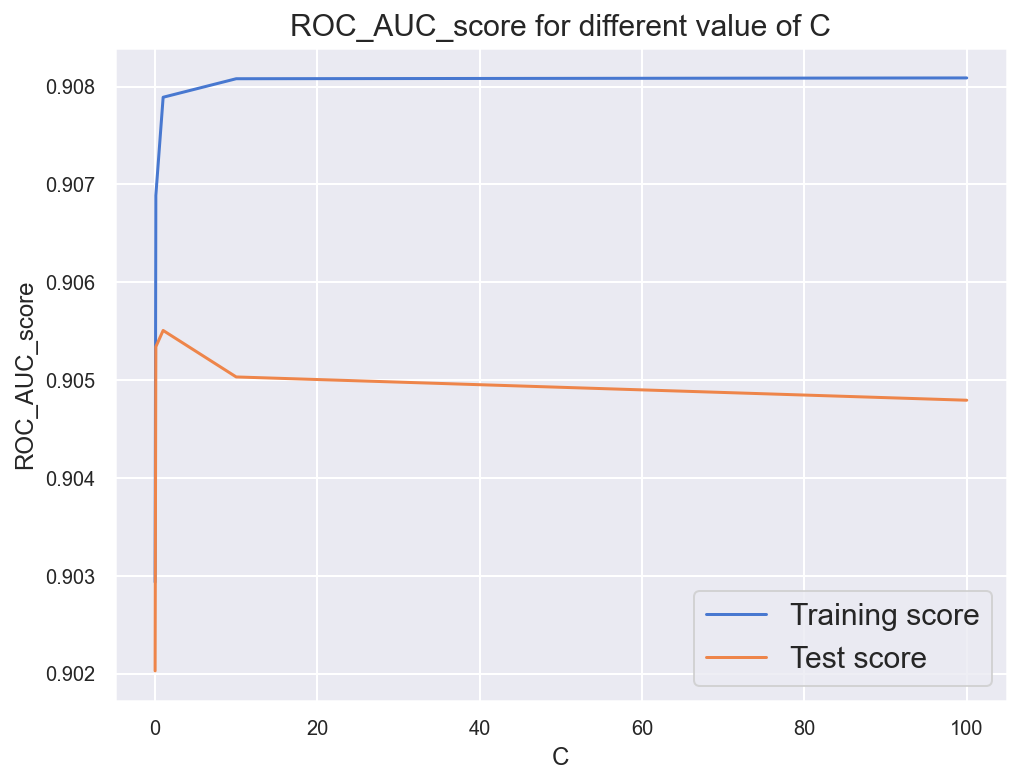

In [17]:
plt.figure(figsize=(8,6))

x = scores_df['param_C']
y1 = scores_df['mean_train_score']
y2 = scores_df['mean_test_score']

plt.plot(x, y1, label='Training score')
plt.plot(x,y2, label='Test score')
plt.title('ROC_AUC_score for different value of C', fontsize=15)
plt.xlabel('C', fontsize=12)
plt.ylabel('ROC_AUC_score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=15)

In [45]:
# Checking test accuracy before moving forward

model_log = LogisticRegression(C=1, max_iter=500, n_jobs=-1).fit(X_train, y_train)

predictions_train = model_log.predict_proba(X_train)

print('ROC_AUC_score for train dataset: ', roc_auc_score(y_train, predictions_train[:,1]))

predictions_test = model_log.predict_proba(X_test)

print('ROC_AUC_score for test dataset: ', roc_auc_score(y_test, predictions_test[:,1]))

ROC_AUC_score for train dataset:  0.9076132104201295
ROC_AUC_score for test dataset:  0.9138988801822951


### Random Forest

In [19]:
# Building Random Forest model using Grid Search

model = RandomForestClassifier(bootstrap=True, oob_score=False, n_jobs=-1, random_state=RANDOM_SEED, verbose=0)

params = {'n_estimators':[3,5,10,13], 'criterion':['gini', 'entropy'], 'max_depth':[3,5,7], 'max_features':[5,7,9,11]}

cv_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

model_cv_rf = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', n_jobs=1, cv= cv_folds, 
                           return_train_score=True, verbose=0)

model_cv_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              

In [20]:
# Checking out the performance of the model

scores_df = pd.DataFrame(model_cv_rf.cv_results_)

scores_df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,rank_test_score,...,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.1790,0.1424,0.7571,0.7553,gini,3,5,3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",95,...,0.7663,0.7595,0.7494,0.7486,0.7383,0.7331,0.1483,0.0387,0.0141,0.0170
1,0.0648,0.1172,0.8463,0.8476,gini,3,5,5,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",86,...,0.8585,0.8538,0.8442,0.8451,0.8425,0.8469,0.0051,0.0015,0.0072,0.0036
2,0.0853,0.1160,0.8730,0.8731,gini,3,5,10,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",64,...,0.8757,0.8731,0.8712,0.8727,0.8746,0.8748,0.0046,0.0004,0.0022,0.0011
3,0.0967,0.1155,0.8762,0.8766,gini,3,5,13,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",55,...,0.8775,0.8748,0.8745,0.8772,0.8798,0.8811,0.0019,0.0013,0.0026,0.0029
4,0.1030,0.1182,0.8422,0.8416,gini,3,7,3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",89,...,0.8398,0.8400,0.8493,0.8495,0.8407,0.8372,0.0702,0.0030,0.0041,0.0047


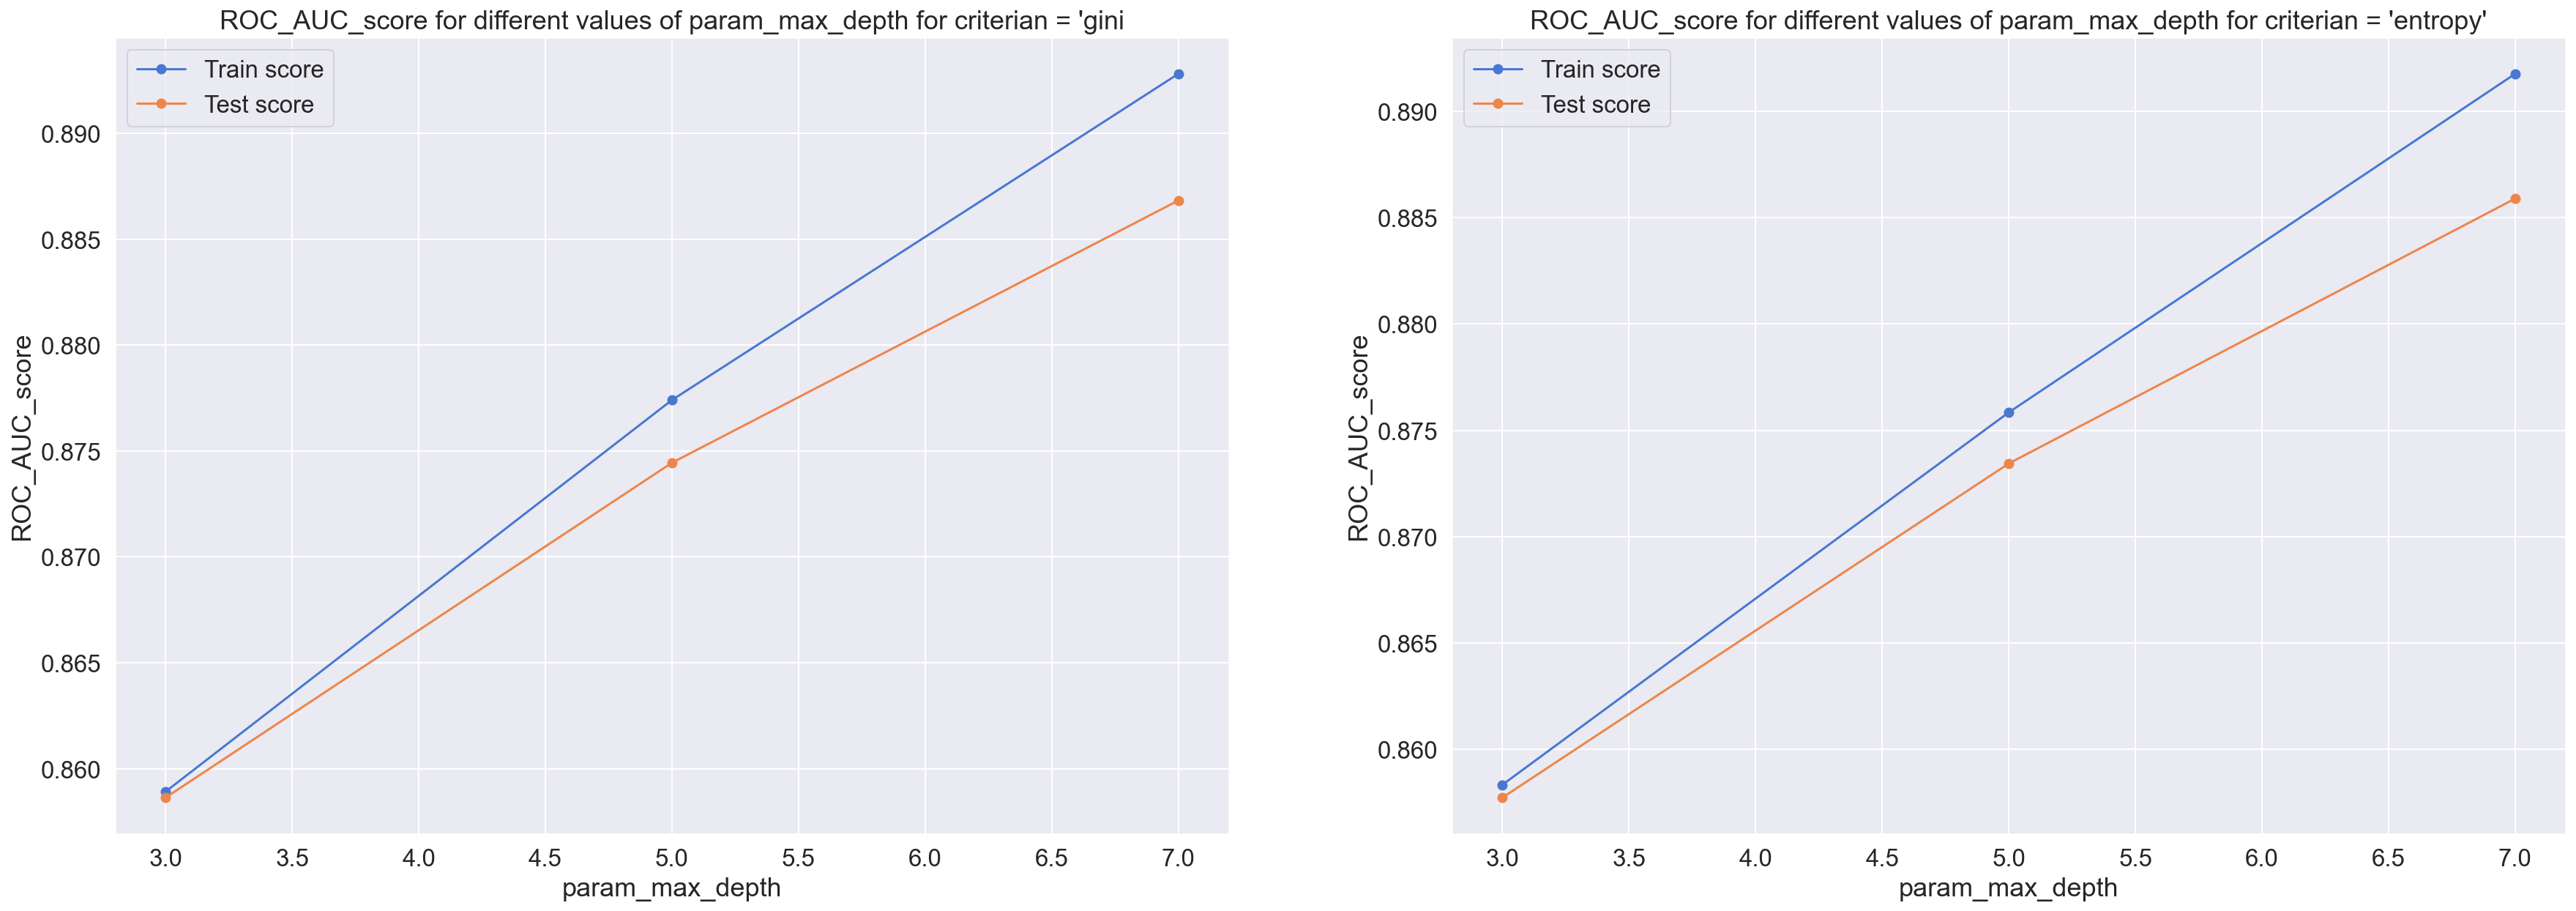

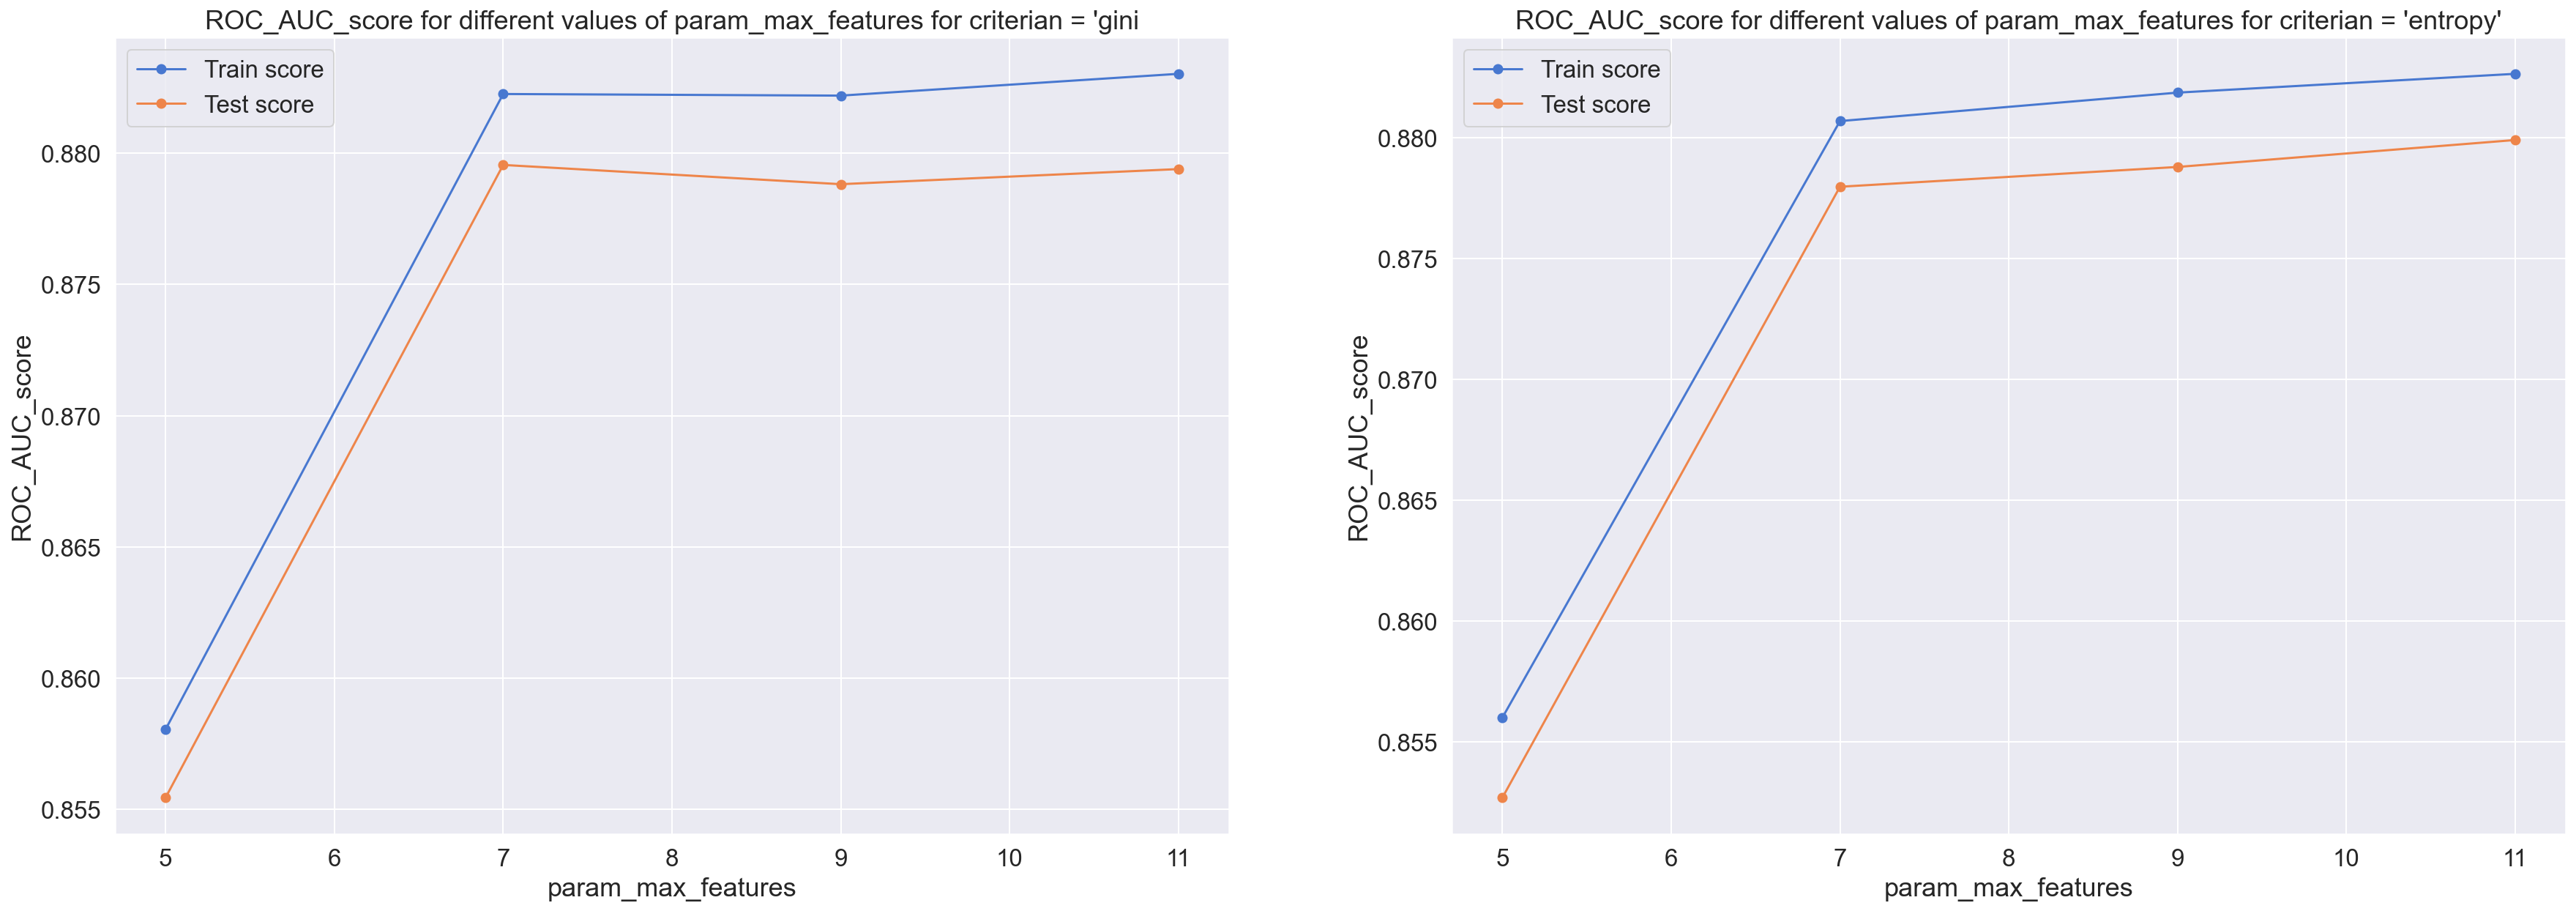

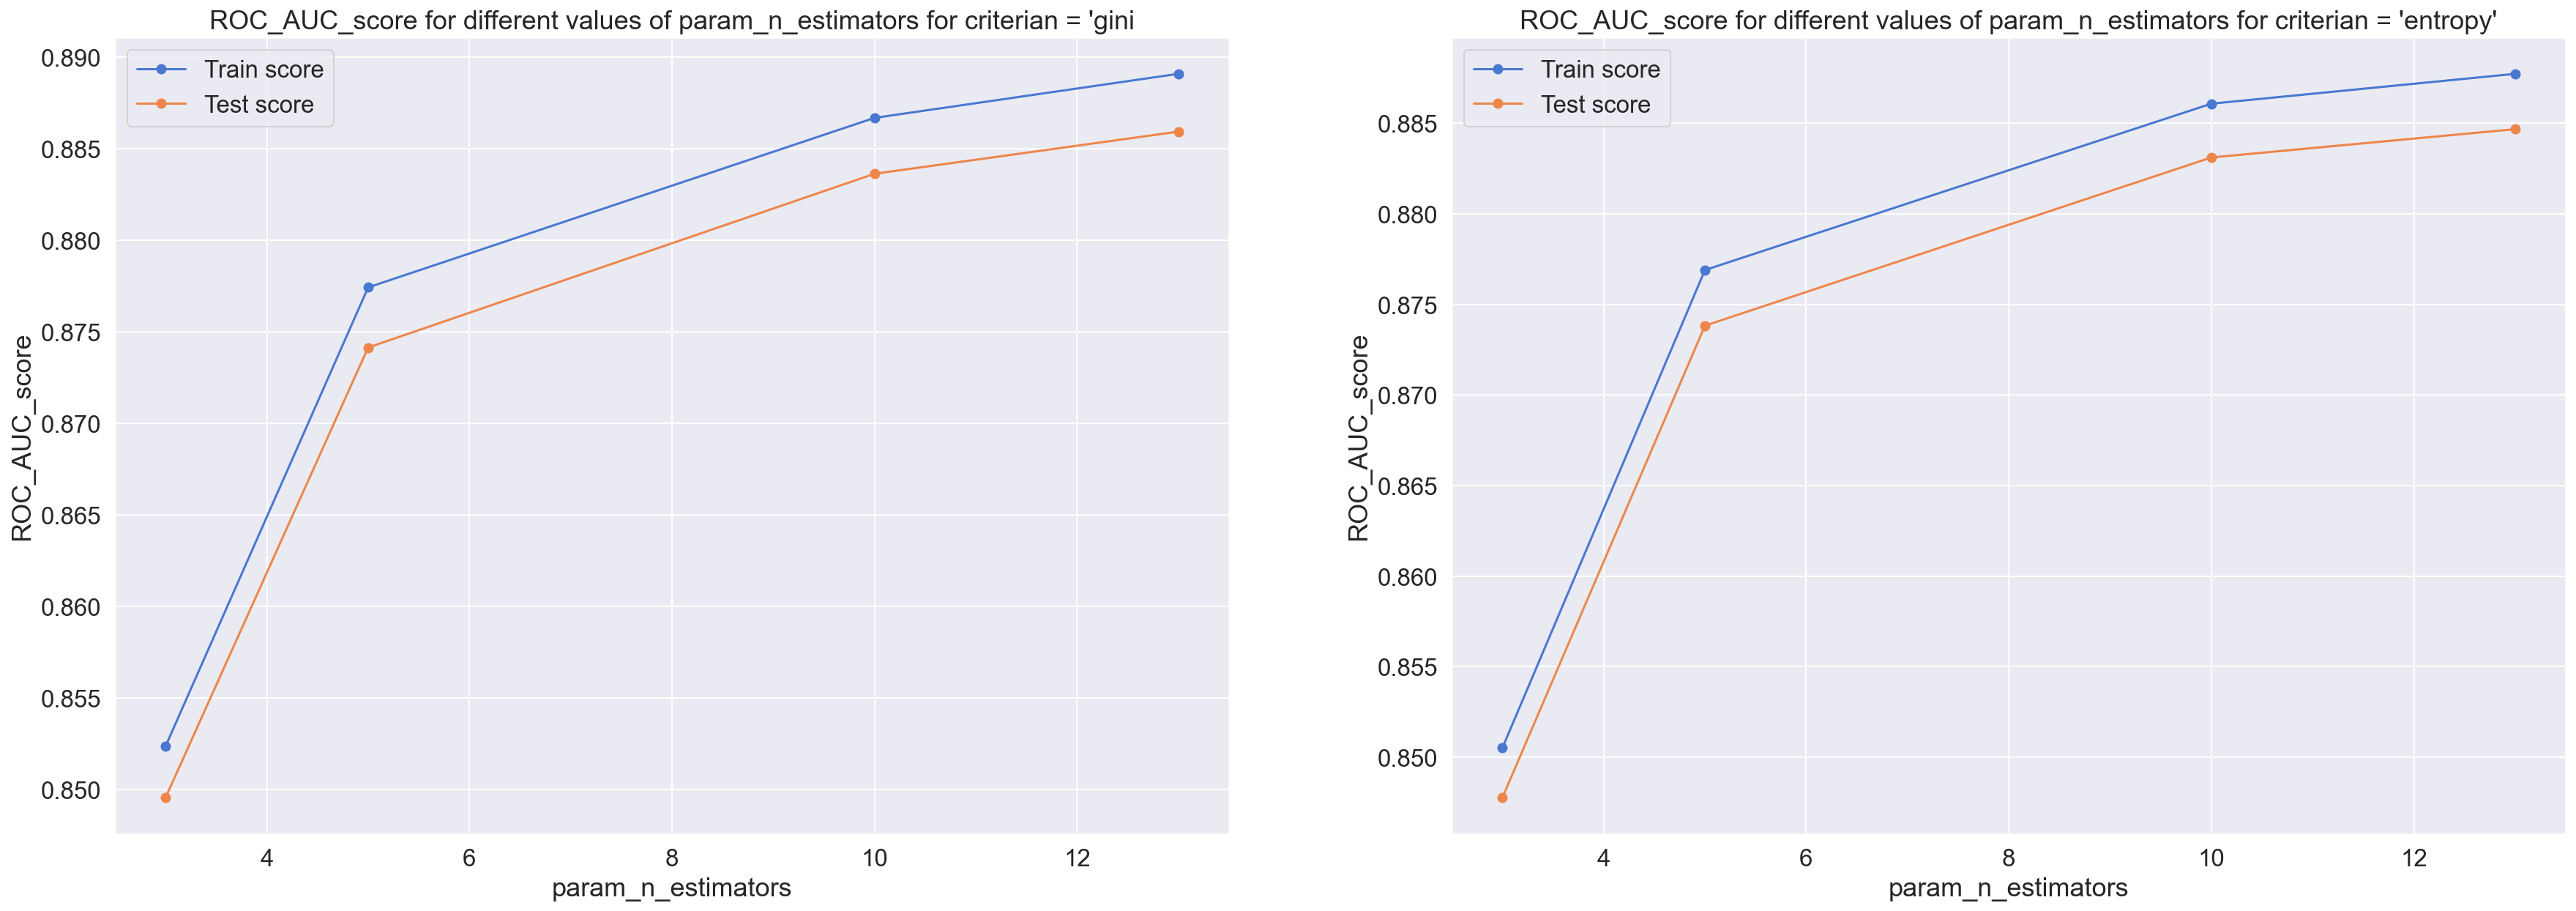

In [21]:
param_list = ['param_max_depth','param_max_features','param_n_estimators']

for param in param_list:

    plt.figure(figsize=(30,10))

    plt.subplot(121)
    df_sub = scores_df.loc[scores_df['param_criterion']=='gini',[param,'mean_test_score','mean_train_score']].groupby([param]).mean()
    plt.plot(df_sub.index, df_sub['mean_train_score'], label='Train score',marker='o')
    plt.plot(df_sub.index, df_sub['mean_test_score'], label='Test score',marker='o')
    plt.legend()
    plt.xlabel(param)
    plt.ylabel('ROC_AUC_score')
    plt.title('ROC_AUC_score for different values of {} for criterian = \'gini'.format(param))


    df_sub = scores_df.loc[scores_df['param_criterion']=='entropy',[param,'mean_test_score','mean_train_score']].groupby([param]).mean()
    plt.subplot(122)
    plt.plot(df_sub.index, df_sub['mean_train_score'], label='Train score', marker='o')
    plt.plot(df_sub.index, df_sub['mean_test_score'], label='Test score', marker='o')
    plt.legend()
    plt.xlabel(param)
    plt.ylabel('ROC_AUC_score')
    plt.title('ROC_AUC_score for different values of {} for criterian = \'entropy\''.format(param))

In [22]:
best_params = scores_df[scores_df['rank_test_score'] == 1]['params']
for param in best_params:
    print(param)

{'criterion': 'gini', 'max_depth': 7, 'max_features': 11, 'n_estimators': 13}


In [23]:
# Building the model with best estimators parameters

model_rf = RandomForestClassifier(bootstrap=True,criterion='gini',max_depth=7, max_features=11, n_estimators=13, n_jobs=-1,
                       oob_score=False, random_state=RANDOM_SEED, verbose=0).fit(X_train, y_train)

predictions_train = model_rf.predict_proba(X_train)

print('ROC_AUC_score for train dataset: ', roc_auc_score(y_train, predictions_train[:,1]))

predictions_test = model_rf.predict_proba(X_test)

print('ROC_AUC_score for test dataset: ', roc_auc_score(y_test, predictions_test[:,1]))

ROC_AUC_score for train dataset:  0.9023678266078381
ROC_AUC_score for test dataset:  0.9004032048486771


### Adaptive Boosting

In [24]:
# Building model with Adaptive Boosting using Grid Search
shallow_tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

model = AdaBoostClassifier(base_estimator=shallow_tree, learning_rate=0.6, algorithm='SAMME', random_state=RANDOM_SEED)

params = {'n_estimators':[20,50, 80, 120], 'base_estimator__criterion': ['gini','entropy'],
          'base_estimator__max_depth':[2,4,6,8], 'base_estimator__max_features':[3,7,11,15]}

cv_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

model_cv_adb = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', n_jobs=1, cv= cv_folds, 
                           return_train_score=True, verbose=0)

model_cv_adb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                 

In [25]:
# Checking out the performance of the model

scores_df = pd.DataFrame(model_cv_adb.cv_results_)

scores_df.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_base_estimator__criterion,param_base_estimator__max_depth,param_base_estimator__max_features,param_n_estimators,params,rank_test_score,...,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.4304,0.0673,0.8600,0.8616,gini,2,3,20,"{'base_estimator__criterion': 'gini', 'base_es...",127,...,0.8570,0.8572,0.8583,0.8643,0.8589,0.8625,0.0080,0.0032,0.0035,0.0026
1,1.0472,0.1616,0.8884,0.8897,gini,2,3,50,"{'base_estimator__criterion': 'gini', 'base_es...",119,...,0.8898,0.8880,0.8862,0.8929,0.8850,0.8863,0.0117,0.0138,0.0030,0.0027
2,1.6830,0.2409,0.8944,0.8958,gini,2,3,80,"{'base_estimator__criterion': 'gini', 'base_es...",114,...,0.8942,0.8928,0.8926,0.8993,0.8926,0.8936,0.0713,0.0033,0.0023,0.0027
3,2.7045,0.4072,0.9049,0.9065,gini,2,3,120,"{'base_estimator__criterion': 'gini', 'base_es...",92,...,0.9053,0.9050,0.9017,0.9089,0.9042,0.9053,0.2609,0.0388,0.0024,0.0015
4,0.4707,0.0698,0.8948,0.8949,gini,2,7,20,"{'base_estimator__criterion': 'gini', 'base_es...",113,...,0.8987,0.8958,0.8893,0.8939,0.8946,0.8948,0.0052,0.0010,0.0035,0.0007
5,1.2220,0.1705,0.9039,0.9045,gini,2,7,50,"{'base_estimator__criterion': 'gini', 'base_es...",96,...,0.9061,0.9037,0.9001,0.9050,0.9034,0.9041,0.0642,0.0061,0.0025,0.0006
6,1.8887,0.2688,0.9095,0.9105,gini,2,7,80,"{'base_estimator__criterion': 'gini', 'base_es...",75,...,0.9123,0.9101,0.9053,0.9111,0.9089,0.9099,0.0901,0.0224,0.0027,0.0005
7,2.7646,0.3807,0.9126,0.9141,gini,2,7,120,"{'base_estimator__criterion': 'gini', 'base_es...",59,...,0.9154,0.9137,0.9085,0.9153,0.9124,0.9135,0.1127,0.0076,0.0026,0.0007
8,0.5333,0.0785,0.8830,0.8838,gini,2,11,20,"{'base_estimator__criterion': 'gini', 'base_es...",125,...,0.8841,0.8840,0.8775,0.8823,0.8853,0.8866,0.0338,0.0067,0.0032,0.0017
9,1.2185,0.1618,0.9030,0.9048,gini,2,11,50,"{'base_estimator__criterion': 'gini', 'base_es...",100,...,0.9044,0.9040,0.8989,0.9062,0.9033,0.9043,0.0417,0.0019,0.0025,0.0009


In [26]:
best_params = scores_df[scores_df['rank_test_score'] == 1]['params']
for param in best_params:
    print(param)

{'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 4, 'base_estimator__max_features': 15, 'n_estimators': 120}


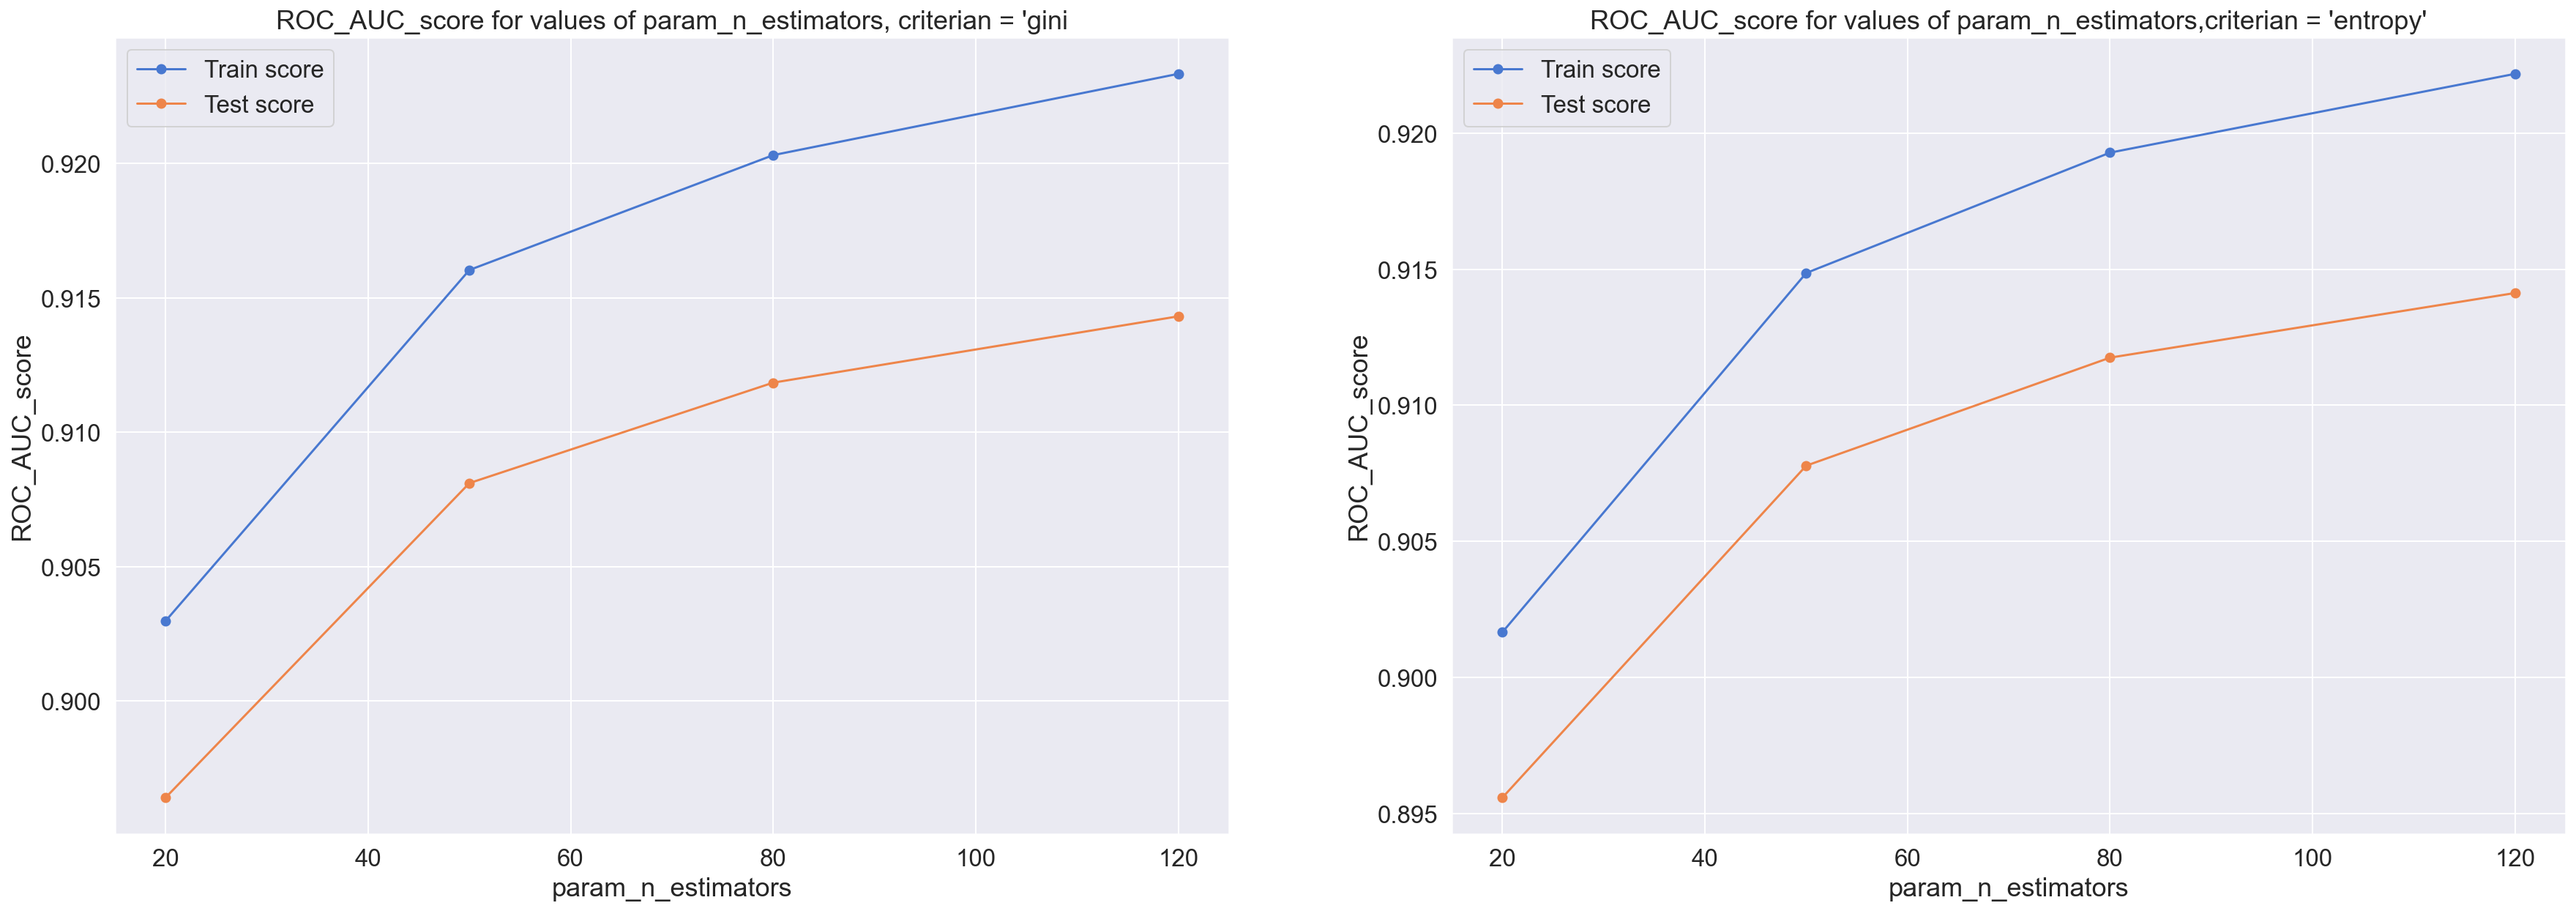

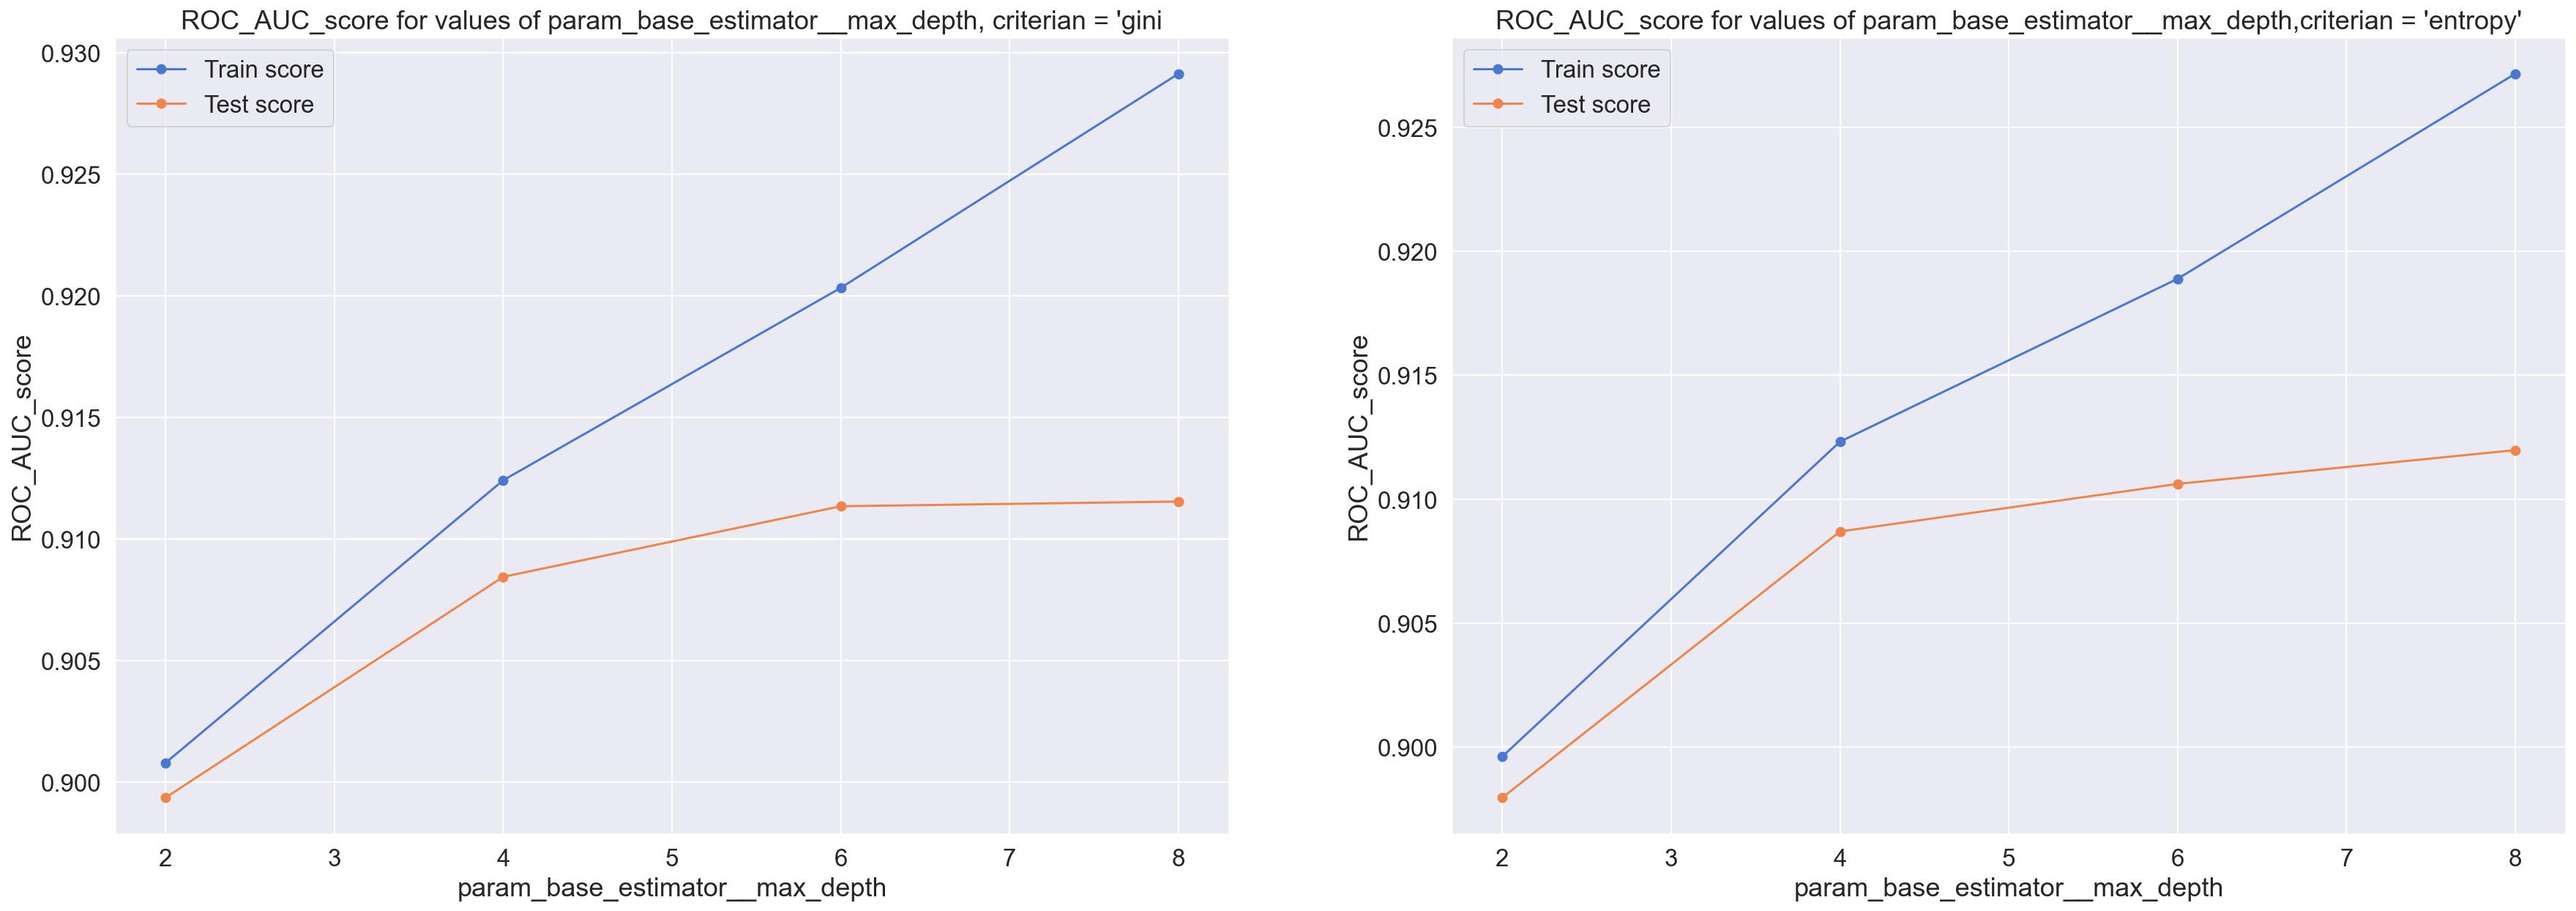

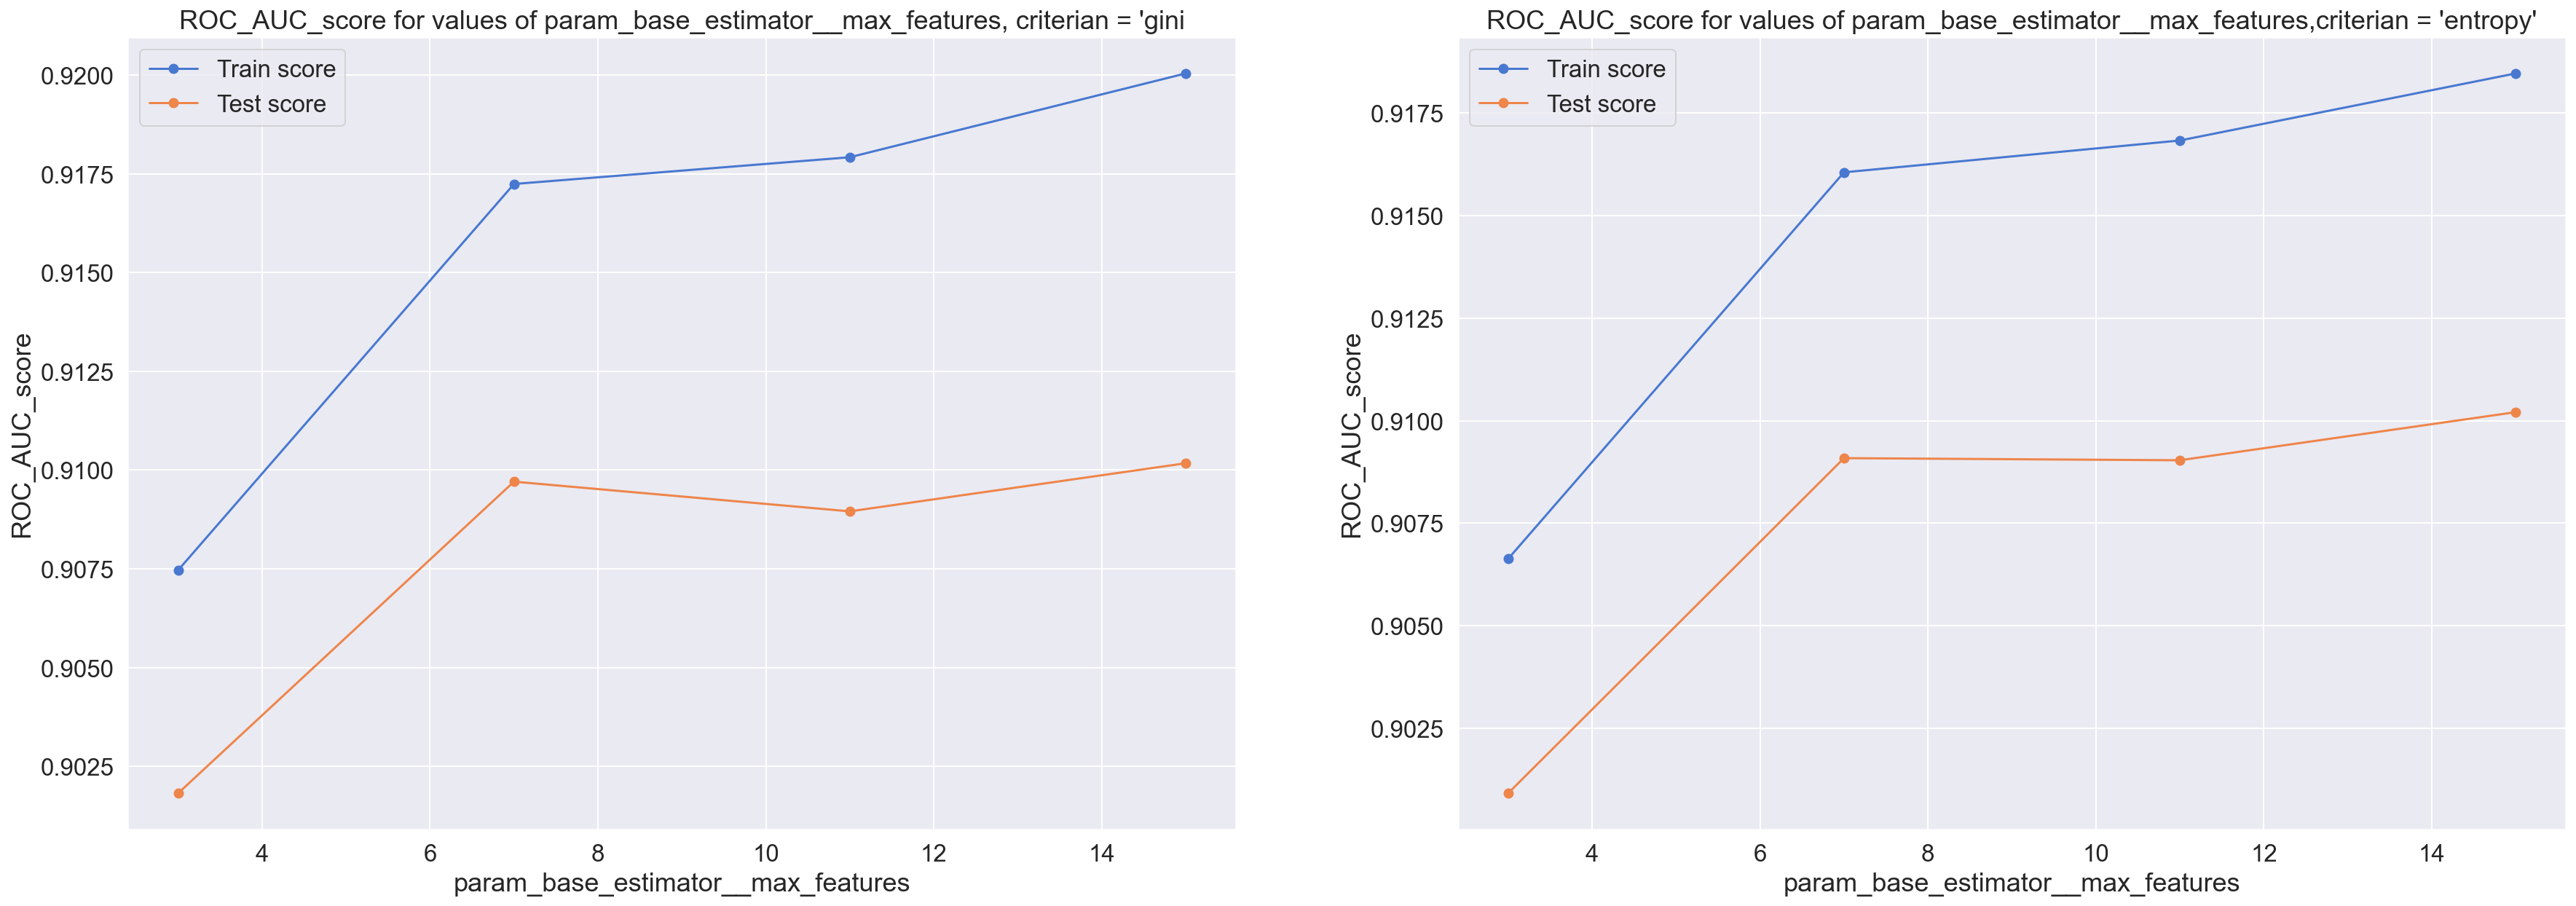

In [27]:
# Visualizing the effect of each parameter separatively

param_list = ['param_n_estimators','param_base_estimator__max_depth','param_base_estimator__max_features']

for param in param_list:

# param = 'param_max_depth'

    plt.figure(figsize=(30,10))

    plt.subplot(121)
    df_sub = scores_df.loc[scores_df['param_base_estimator__criterion']=='gini',[param,'mean_test_score','mean_train_score']].groupby([param]).mean()
    plt.plot(df_sub.index, df_sub['mean_train_score'], label='Train score', marker='o')
    plt.plot(df_sub.index, df_sub['mean_test_score'], label='Test score', marker='o')
    plt.legend()
    plt.xlabel(param)
    plt.ylabel('ROC_AUC_score')
    plt.title('ROC_AUC_score for values of {}, criterian = \'gini'.format(param))


    df_sub = scores_df.loc[scores_df['param_base_estimator__criterion']=='entropy',[param,'mean_test_score','mean_train_score']].groupby([param]).mean()
    plt.subplot(122)
    plt.plot(df_sub.index, df_sub['mean_train_score'], label='Train score', marker='o')
    plt.plot(df_sub.index, df_sub['mean_test_score'], label='Test score', marker='o')
    plt.legend()
    plt.xlabel(param)
    plt.ylabel('ROC_AUC_score')
    plt.title('ROC_AUC_score for values of {},criterian = \'entropy\''.format(param))

In [28]:
# Building the model with best estimators parameters

shallow_tree = DecisionTreeClassifier(random_state=RANDOM_SEED, criterion='gini', max_depth=4, max_features=15)

model_adb = AdaBoostClassifier(base_estimator=shallow_tree, learning_rate=0.6, algorithm='SAMME', random_state=RANDOM_SEED,
                               n_estimators=120)

model = model_adb.fit(X_train,y_train)

predictions_train = model.predict_proba(X_train)

print('ROC_AUC_score for train dataset: ', roc_auc_score(y_train, predictions_train[:,1]))

predictions_test = model.predict_proba(X_test)

print('ROC_AUC_score for test dataset: ', roc_auc_score(y_test, predictions_test[:,1]))

ROC_AUC_score for train dataset:  0.9203267359634059
ROC_AUC_score for test dataset:  0.9203464137790287


### Extreme Gradient Boosting

In [ ]:
# Building model with Extreme Gradient Boosting using Grid Search

model = XGBClassifier(n_jobs=-1, verbosity=1, random_state=RANDOM_SEED)

params = {'learning_rate':[0.1, 0.3, 0.5], 'max_depth':[2,4,6], 'sub_sample':[0.3,0.6,0.9], 'colsample_bytree':[0.4,0.8,1]}

cv_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

model_cv_xgb = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', n_jobs=1, cv= cv_folds, 
                           return_train_score=True, verbose=0)

model_cv_xgb.fit(X_train, y_train)

In [30]:
# Checking out the performance of the model

scores_df = pd.DataFrame(model_cv_xgb.cv_results_)

scores_df.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_learning_rate,param_max_depth,param_sub_sample,params,rank_test_score,...,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.8124,0.0975,0.9148,0.9168,0.4000,0.1000,2,0.3000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",79,...,0.9182,0.9159,0.9109,0.9181,0.9148,0.9165,0.2050,0.0026,0.0026,0.0008
1,1.4741,0.0923,0.9148,0.9168,0.4000,0.1000,2,0.6000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",79,...,0.9182,0.9159,0.9109,0.9181,0.9148,0.9165,0.0896,0.0027,0.0026,0.0008
2,1.5514,0.0990,0.9148,0.9168,0.4000,0.1000,2,0.9000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",79,...,0.9182,0.9159,0.9109,0.9181,0.9148,0.9165,0.0936,0.0053,0.0026,0.0008
3,2.1747,0.1007,0.9264,0.9331,0.4000,0.1000,4,0.3000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",67,...,0.9297,0.9320,0.9222,0.9337,0.9280,0.9335,0.0636,0.0037,0.0028,0.0007
4,2.3801,0.0987,0.9264,0.9331,0.4000,0.1000,4,0.6000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",67,...,0.9297,0.9320,0.9222,0.9337,0.9280,0.9335,0.1814,0.0043,0.0028,0.0007
5,2.2612,0.0990,0.9264,0.9331,0.4000,0.1000,4,0.9000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",67,...,0.9297,0.9320,0.9222,0.9337,0.9280,0.9335,0.1597,0.0047,0.0028,0.0007
6,2.9386,0.1017,0.9319,0.9450,0.4000,0.1000,6,0.3000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",34,...,0.9349,0.9439,0.9290,0.9458,0.9325,0.9445,0.1122,0.0072,0.0021,0.0008
7,2.9858,0.1037,0.9319,0.9450,0.4000,0.1000,6,0.6000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",34,...,0.9349,0.9439,0.9290,0.9458,0.9325,0.9445,0.1418,0.0043,0.0021,0.0008
8,2.9945,0.1015,0.9319,0.9450,0.4000,0.1000,6,0.9000,"{'colsample_bytree': 0.4, 'learning_rate': 0.1...",34,...,0.9349,0.9439,0.9290,0.9458,0.9325,0.9445,0.1795,0.0032,0.0021,0.0008
9,1.5810,0.0940,0.9260,0.9300,0.4000,0.3000,2,0.3000,"{'colsample_bytree': 0.4, 'learning_rate': 0.3...",70,...,0.9299,0.9294,0.9227,0.9316,0.9262,0.9293,0.1633,0.0038,0.0026,0.0009


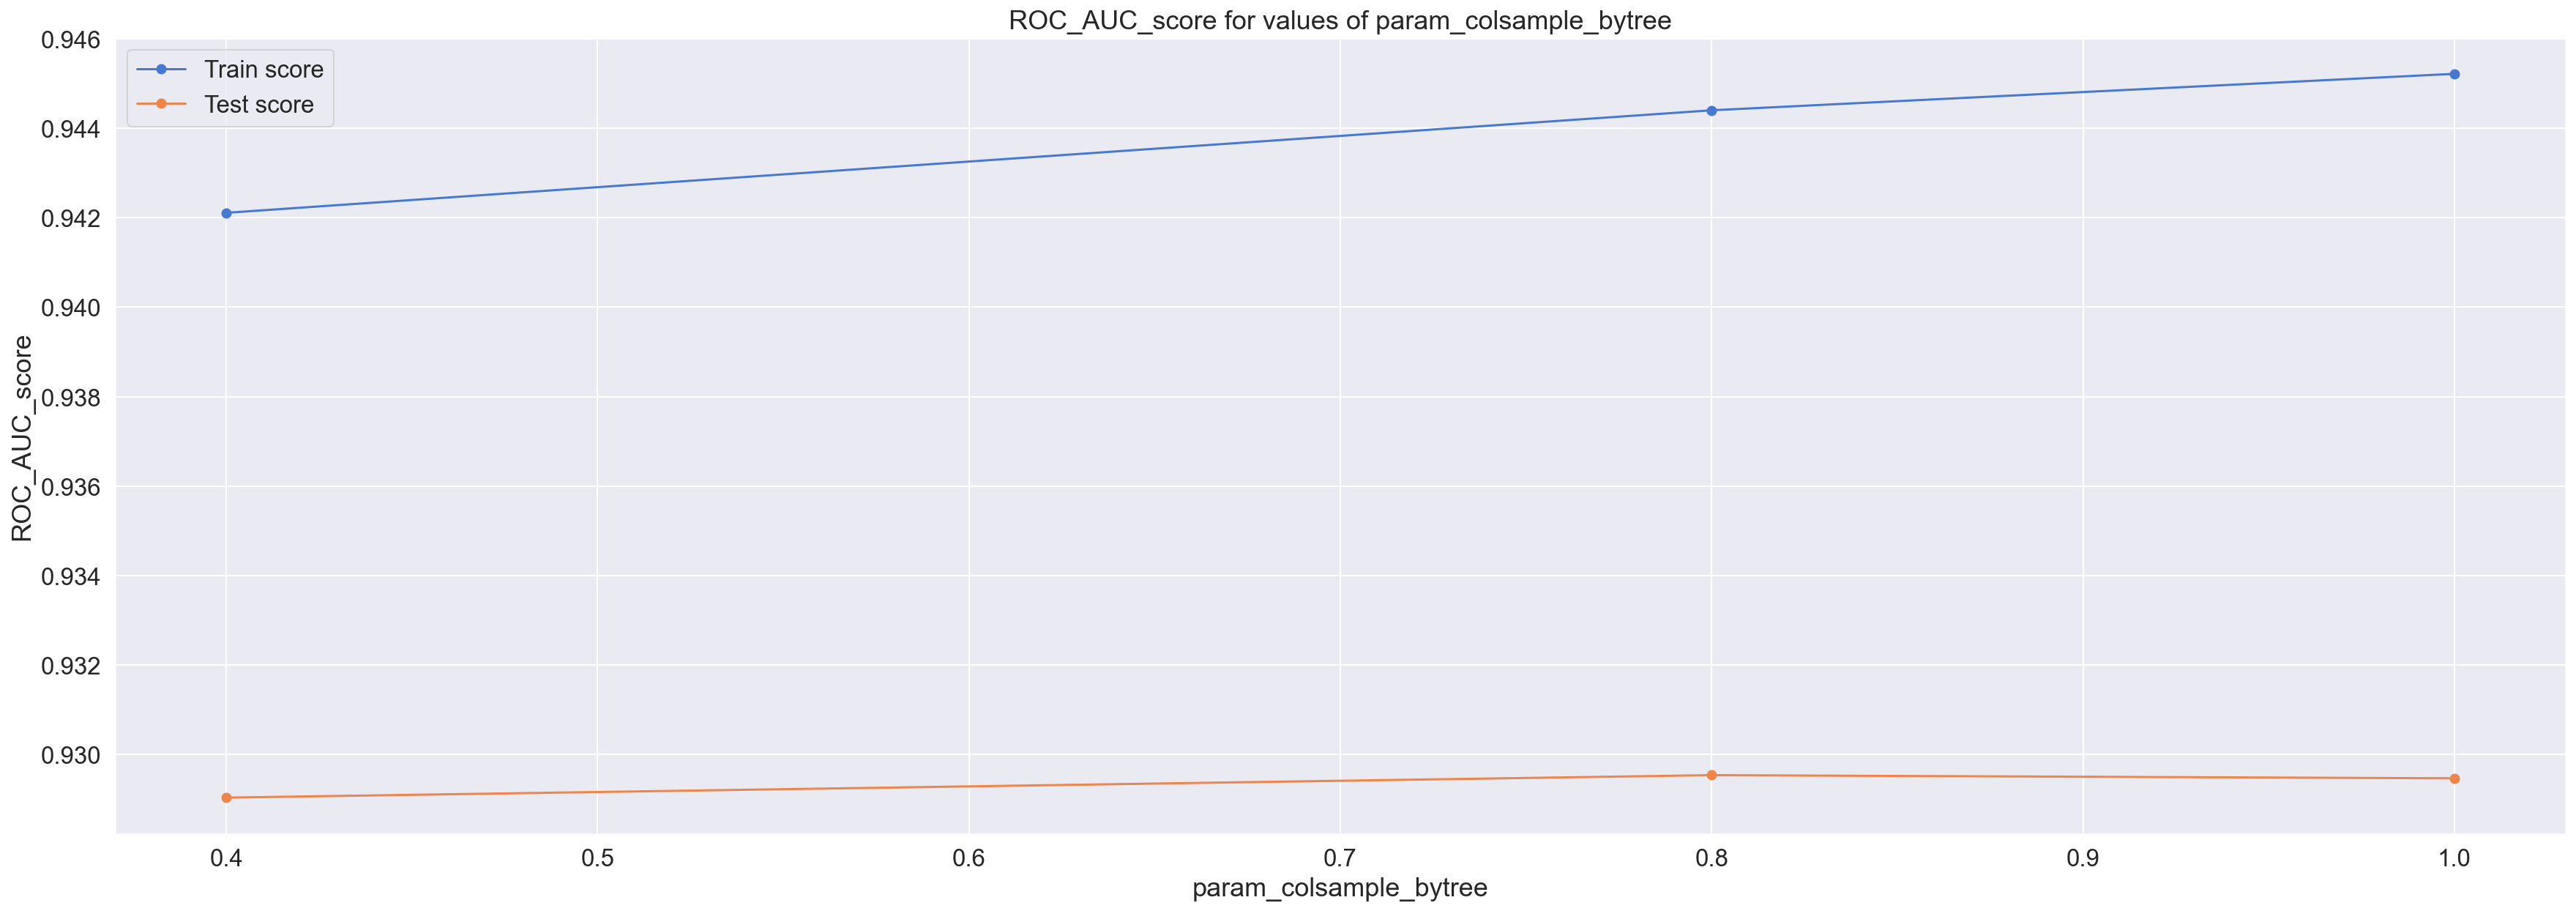

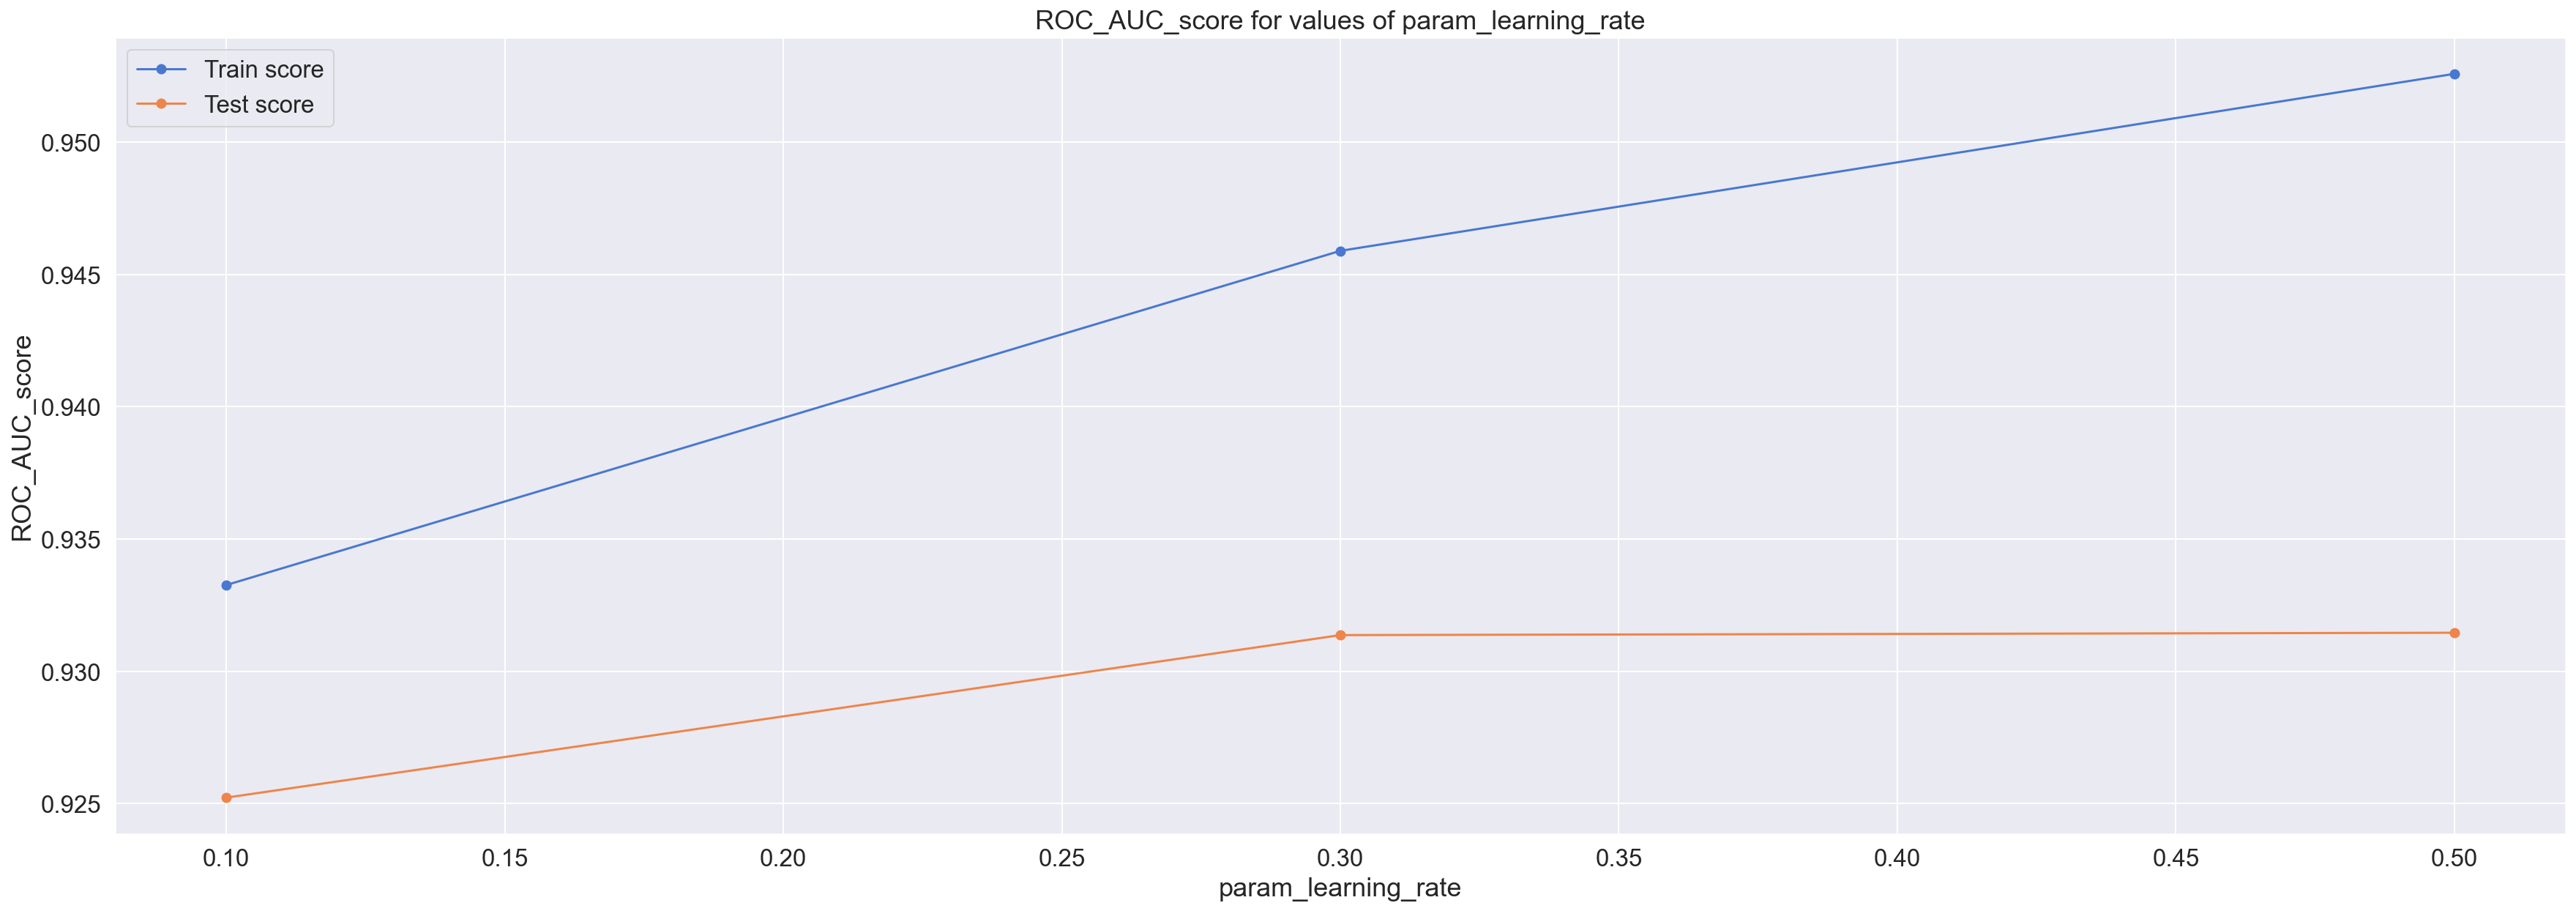

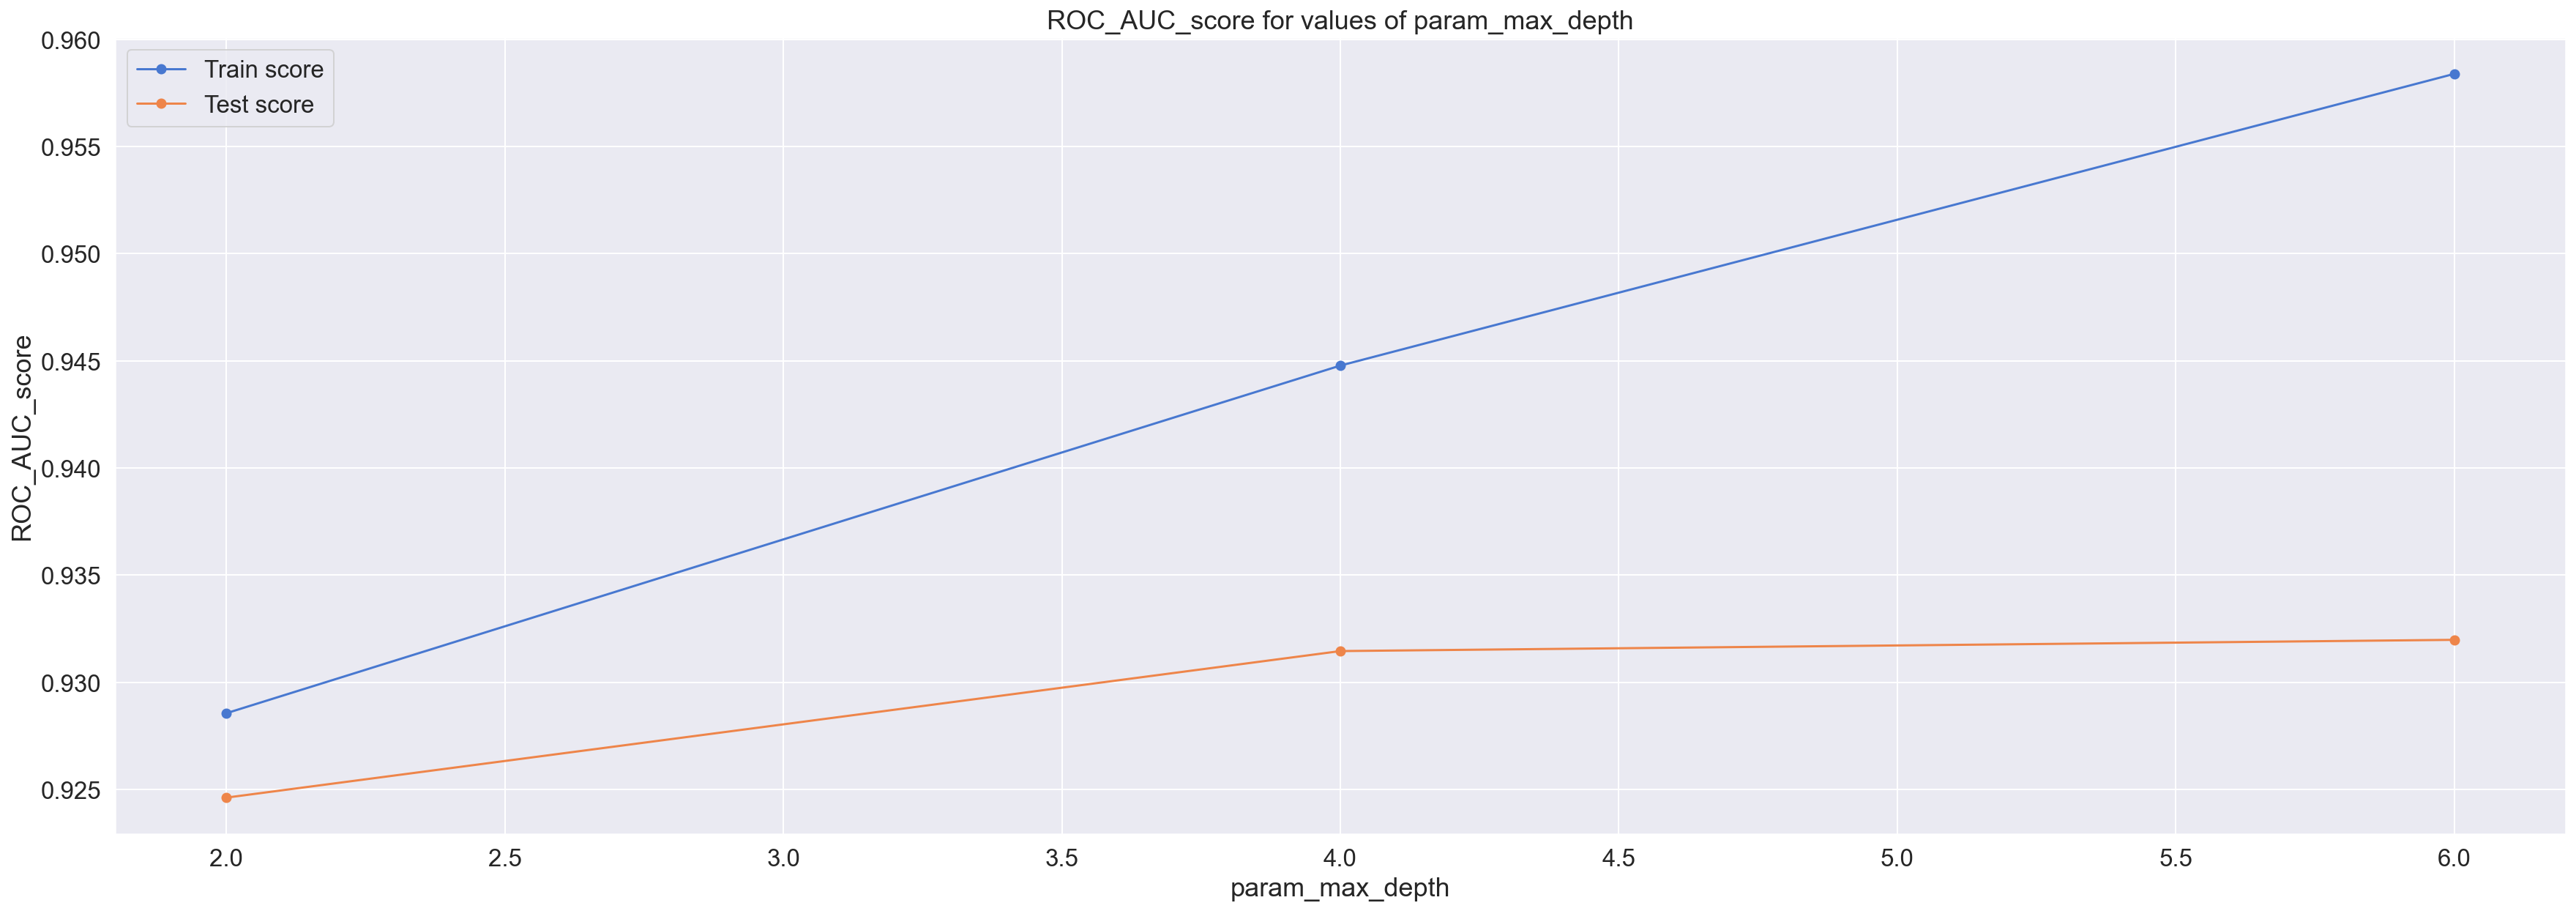

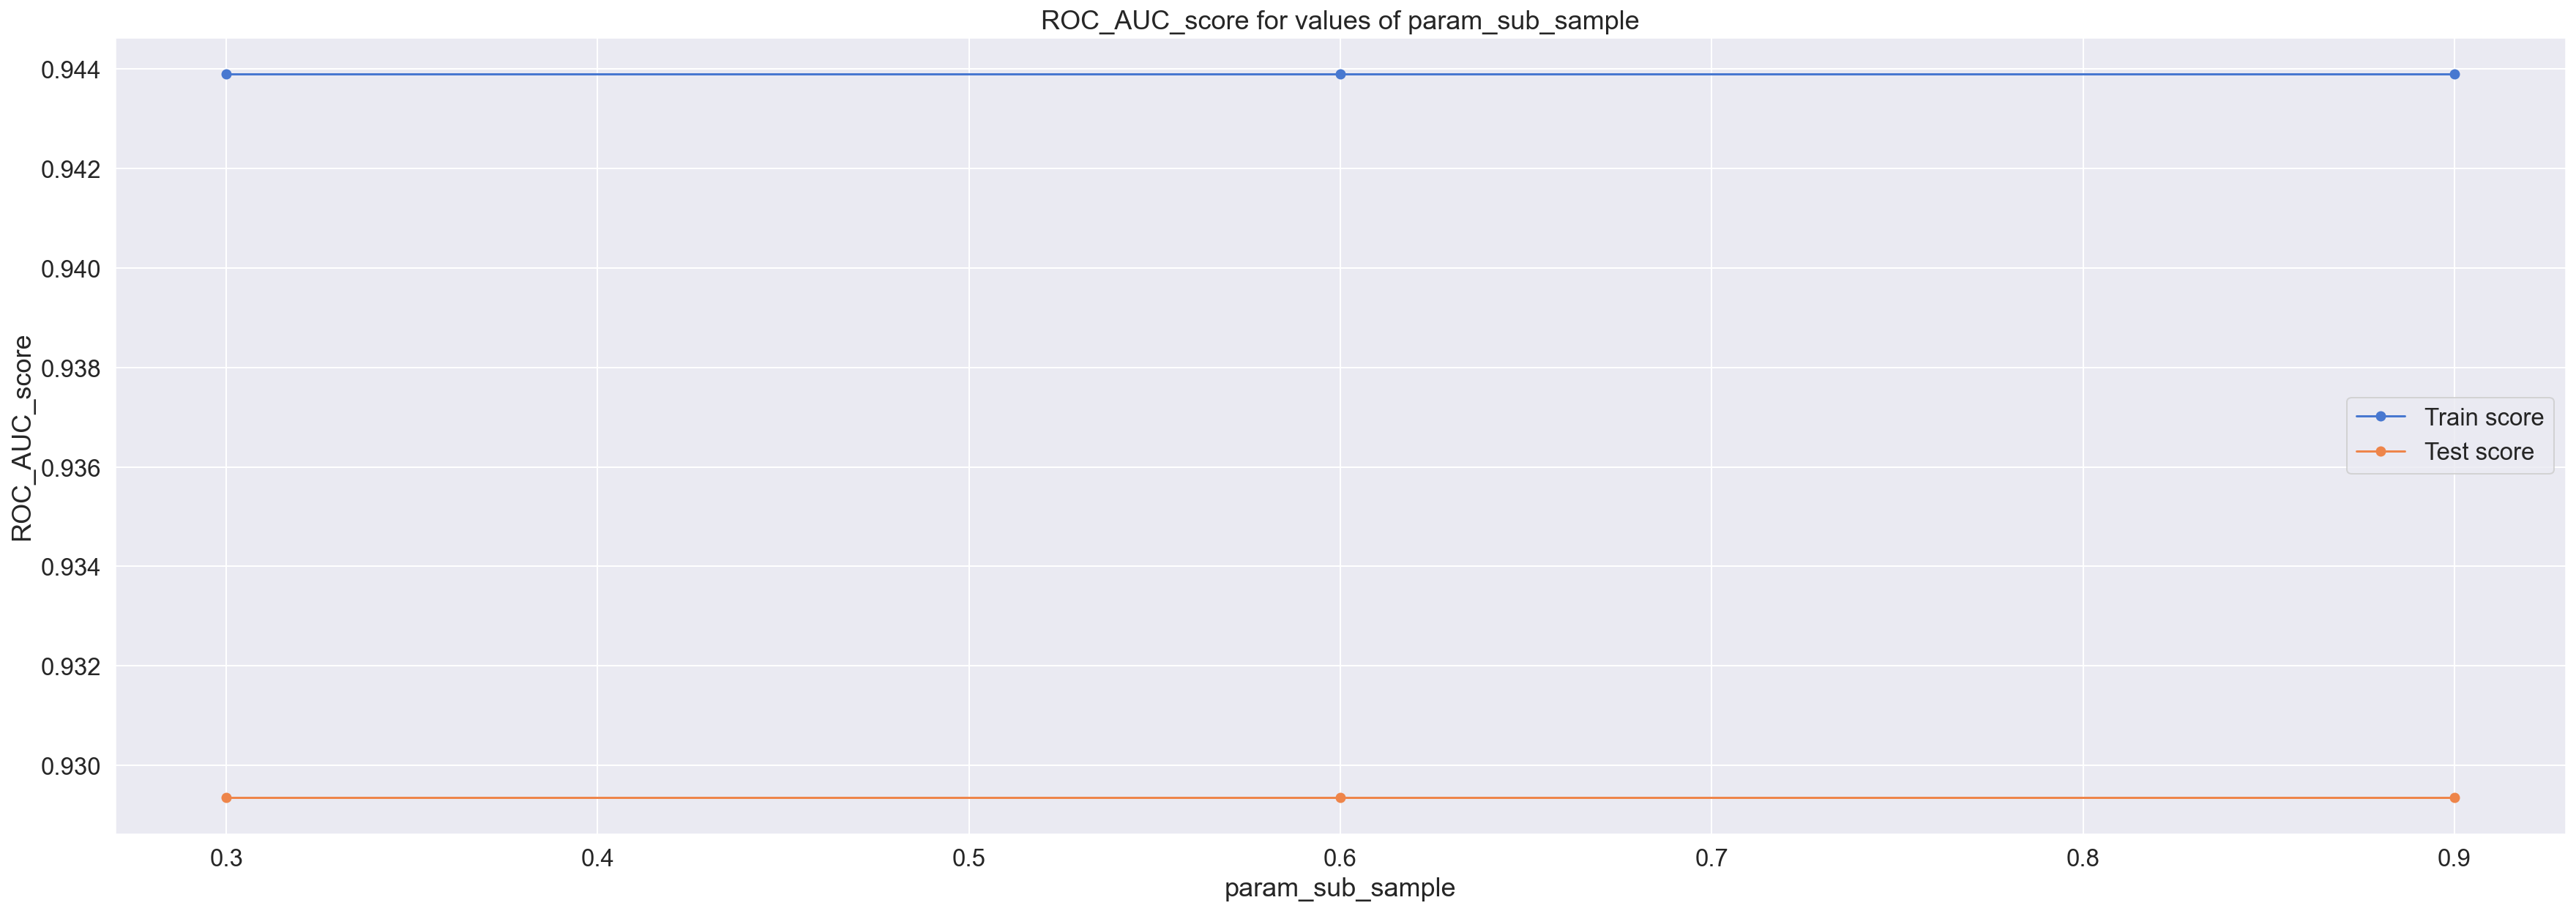

In [31]:
# Visualizing effect of each parameter separatively

param_list = ['param_colsample_bytree','param_learning_rate','param_max_depth','param_sub_sample']

for param in param_list:
    plt.figure(figsize=(30,10))

    df_sub = scores_df[[param,'mean_test_score','mean_train_score']].groupby([param]).mean()
    plt.plot(df_sub.index, df_sub['mean_train_score'], label='Train score', marker='o')
    plt.plot(df_sub.index, df_sub['mean_test_score'], label='Test score', marker='o')
    plt.legend()
    plt.xlabel(param)
    plt.ylabel('ROC_AUC_score')
    plt.title('ROC_AUC_score for values of {}'.format(param))

In [33]:
# Building the model with best estimators parameters

model_xgb = XGBClassifier(n_jobs=-1, verbosity=1, random_state=RANDOM_SEED, colsample_bytree=1, learning_rate=0.3, max_depth=4,
                          sub_sample=0.3).fit(X_train,y_train)

model = model_xgb

predictions_train = model.predict_proba(X_train)

print('ROC_AUC_score for train dataset: ', roc_auc_score(y_train, predictions_train[:,1]))

predictions_test = model.predict_proba(X_test)

print('ROC_AUC_score for test dataset: ', roc_auc_score(y_test, predictions_test[:,1]))

[17:33:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ROC_AUC_score for train dataset:  0.9458746736219977
ROC_AUC_score for test dataset:  0.9368510614556308


In [34]:
best_params = scores_df[scores_df['rank_test_score'] == 1]['params']
for param in best_params:
    print(param)

{'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 4, 'sub_sample': 0.3}
{'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 4, 'sub_sample': 0.6}
{'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 4, 'sub_sample': 0.9}


In [35]:
# Building the model with best estimators parameters

model_xgb = XGBClassifier(n_jobs=-1, verbosity=1, random_state=RANDOM_SEED, colsample_bytree=1, learning_rate=0.3, max_depth=6,
                          sub_sample=0.3).fit(X_train,y_train)

model = model_xgb

predictions_train = model.predict_proba(X_train)

print('ROC_AUC_score for train dataset: ', roc_auc_score(y_train, predictions_train[:,1]))

predictions_test = model.predict_proba(X_test)

print('ROC_AUC_score for test dataset: ', roc_auc_score(y_test, predictions_test[:,1]))

[17:33:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ROC_AUC_score for train dataset:  0.958144790089981
ROC_AUC_score for test dataset:  0.9360472945691705


## Model Validation

### Finding optimal threshold using ROC-AUC 

fpr at threshold = 0.5: [0.05086897]
tpr at threshold = 0.5: [0.65233083]


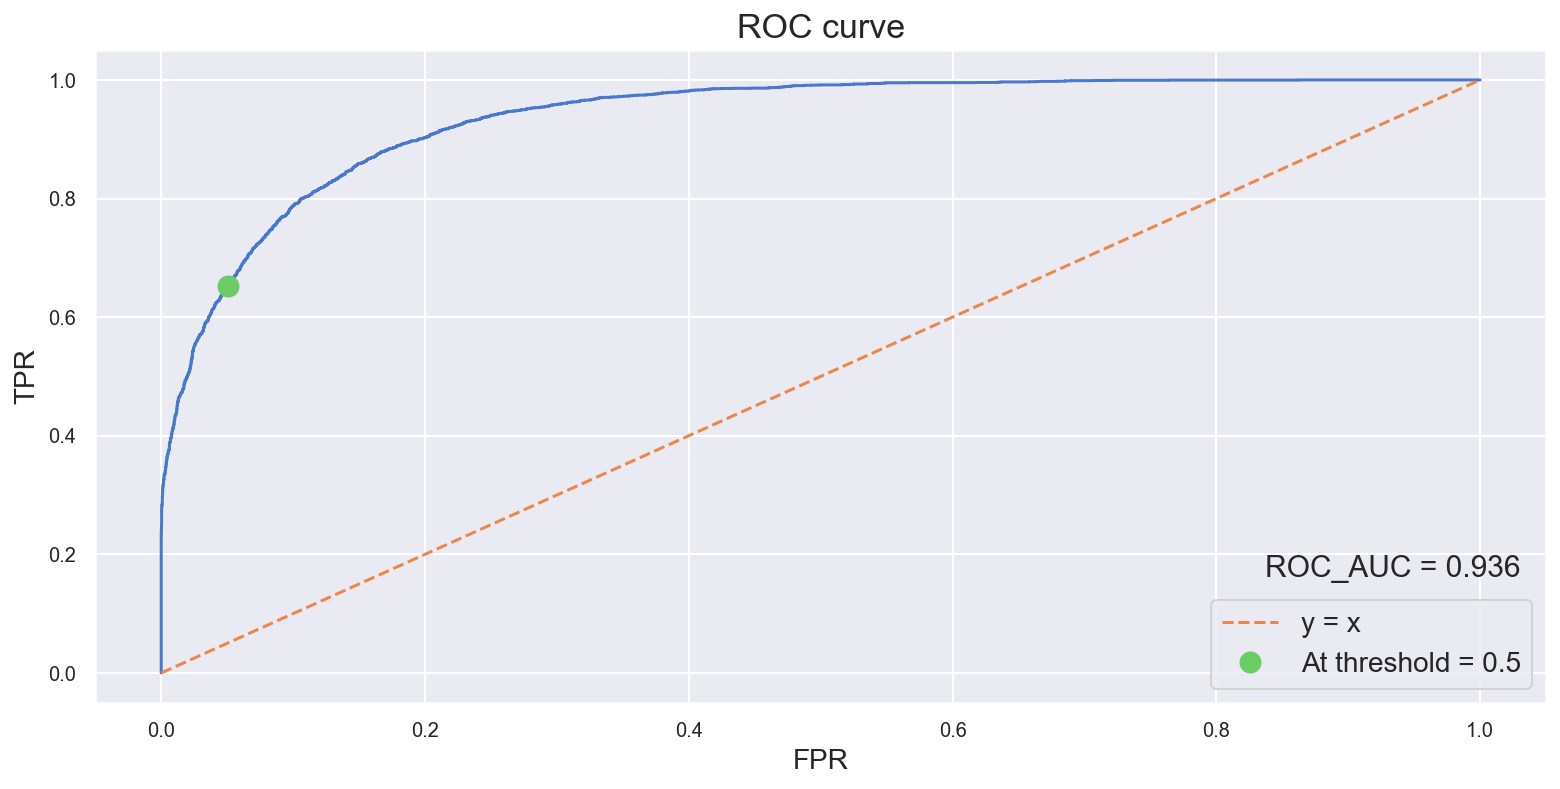

In [36]:
predictions = model.predict_proba(X_test)[:,1]

auc = round(roc_auc_score(y_test, predictions),3)

fpr, tpr, thresholds = roc_curve(y_test, predictions, drop_intermediate=True)

threshold_centre = thresholds[np.round(thresholds,1)==0.5][0]

index = np.where(thresholds==threshold_centre)[0]

fpr_centre = fpr[index]
tpr_centre = tpr[index]

plt.figure(figsize=(13,6))
plt.plot(fpr, tpr, '-')
plt.plot([0,1],[0,1],'--', label='y = x')
plt.gcf().text(0.75,0.27,s='ROC_AUC = {}'.format(auc), fontsize=15);
plt.title('ROC curve',fontsize=17)
plt.xlabel('FPR', fontsize=14);
plt.ylabel('TPR', fontsize=14);
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.plot(fpr_centre, tpr_centre,'o', label='At threshold = 0.5', markersize=10)

# plt.plot([0,fpr_centre],[tpr_centre,tpr_centre],'--r')
# plt.plot([fpr_centre, fpr_centre],[0,tpr_centre],'--', label='at threshold = 0.5')
plt.legend(fontsize=14)

print('fpr at threshold = 0.5: {}'.format(fpr_centre))
print('tpr at threshold = 0.5: {}'.format(tpr_centre))

In [37]:
# Most optimal value of threshold

# Considering all values of threshold now
fpr, tpr, thresholds = roc_curve(y_test, predictions, drop_intermediate=False)

threshold_df = pd.DataFrame({'threshold':thresholds,'tpr':tpr, 'fpr':fpr})

threshold_df['score'] = threshold_df['tpr'] + (1 - threshold_df['fpr'])

max_score = max(threshold_df['score'])

threshold = threshold_df.loc[threshold_df['score']==max_score,'threshold'].values[0]

print('Threshold under which max score({0}) is obtained: {1}'.format(round(max_score,3),round(threshold,3)))

Threshold under which max score(1.712) is obtained: 0.24400000274181366


In [38]:
# Checking classification report for this threshold value

final_df = pd.DataFrame({'y_true':y_test,'y_prob':predictions})

final_df['y_pred'] = final_df['y_prob'].apply(lambda x: 1 if x>threshold else 0)

print(confusion_matrix(final_df['y_true'], final_df['y_pred']))

[[8536 1706]
 [ 405 2920]]


In [39]:
def plot_cm(labels, predictions, p=0.5):
    tick_labels = ['Not Aprroved', 'Approved']

    cm = confusion_matrix(labels, predictions > p)
    ax = sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)

### Confusion Matrix

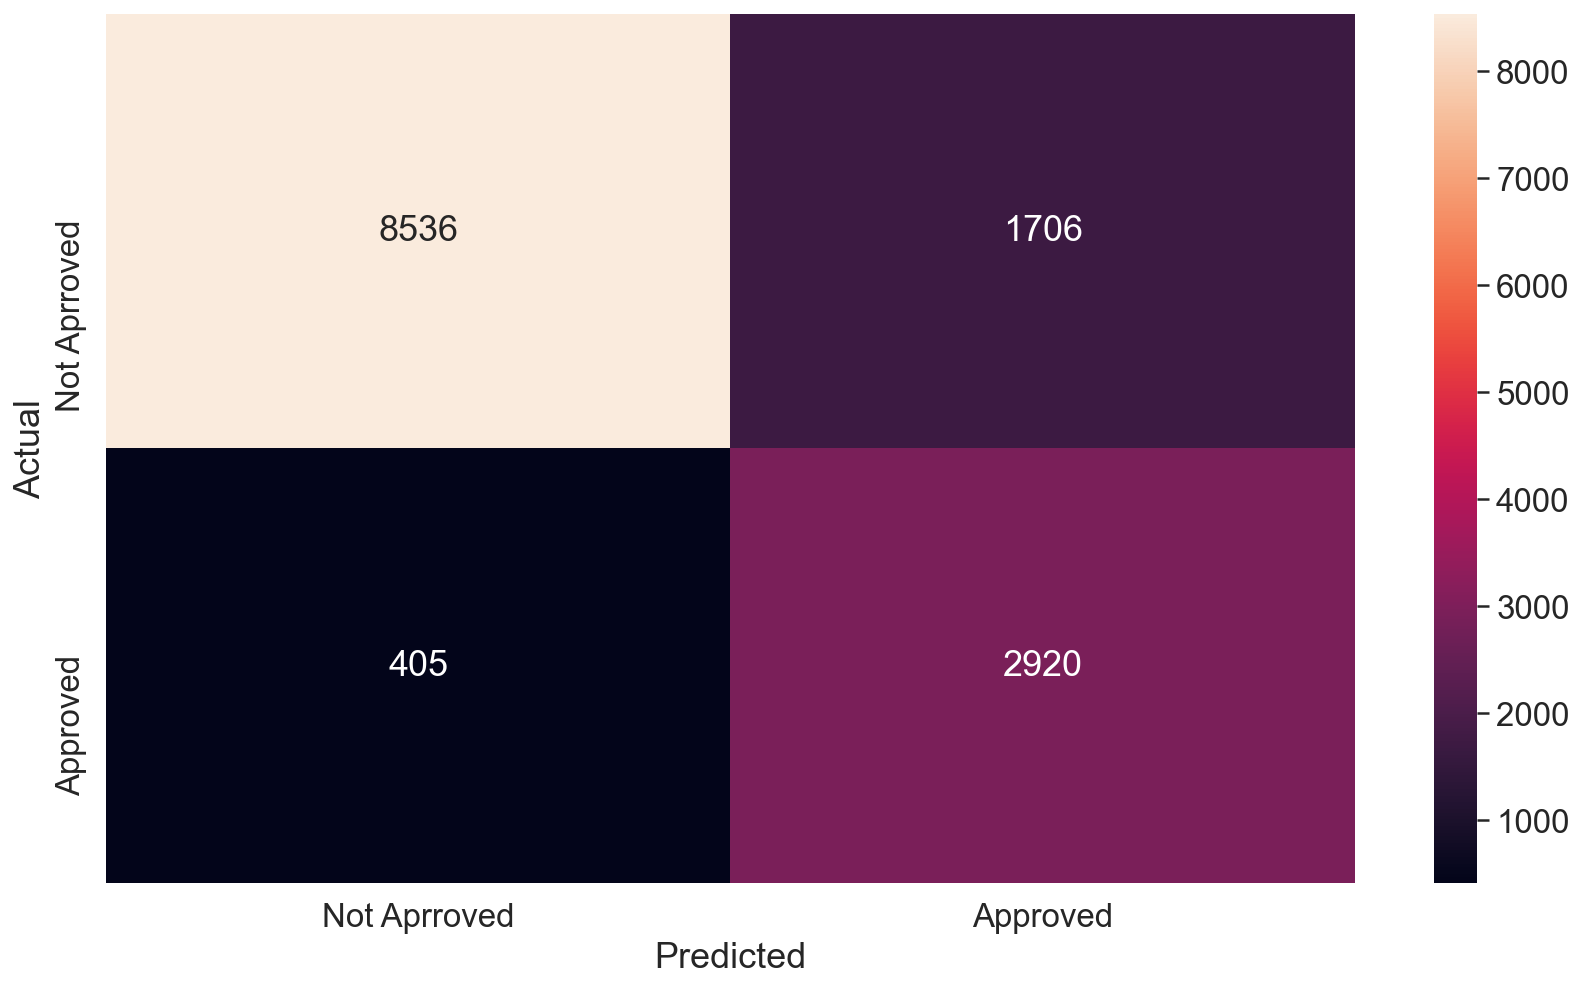

In [40]:
# Confusion Matrix
plot_cm(final_df['y_true'], final_df['y_pred'], threshold)

In [41]:
# Generating classification_report to take the informed decision

print(classification_report(final_df['y_true'], final_df['y_pred']))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10242
           1       0.63      0.88      0.73      3325

    accuracy                           0.84     13567
   macro avg       0.79      0.86      0.81     13567
weighted avg       0.88      0.84      0.85     13567



### Conclusion

- XGBoost gives best AUC-ROC value for test set which is why we used it as the final model
- As we can see, precision is good along with the accuracy of 84% if we use the probability threshold to be 0.24.
- Apart from the steps followed above, we can also try a few things 
    1. Input dataset could be used without one hot encoding with tree based models
    2. More parameter values could be used to do an exhaustive grid search to see if there is a scope of improvement
    3. We can try running all these model after handling the class imbalance in the target variable(for this we can use any one of the following techniques: oversampling, undersampling, class weights, SMOTE)
    4. Predict credit limit using the probability values obtained during classification(credit limit = f(probability))


### Saving the model

In [44]:
file_name = "../model/xgb_credit_card.pkl"

# save
pickle.dump(model, open(file_name, "wb"))